In [13]:
import scyan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from gmvae_final_aml import GMVAE
import torch
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, balanced_accuracy_score
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
from sklearn.metrics import recall_score, f1_score, confusion_matrix

In [14]:
def per_cluster_metrics(dataloader, model, label_names=None):

    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x_true, c_true in dataloader:
            x_true = x_true.to(model.device)
            c_true = c_true.to(model.device)
            q_c_x = F.softmax(model.q_c_x(x_true), dim=-1)
            c_pred = torch.multinomial(q_c_x, 1, replacement=True).squeeze()
            all_true.append(c_true.cpu().numpy())
            all_pred.append(c_pred.cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    # Per-class recall and F1
    recall = recall_score(y_true, y_pred, average=None, labels=np.unique(y_true))
    f1 = f1_score(y_true, y_pred, average=None, labels=np.unique(y_true))

    # Map to label names if provided
    if label_names is not None:
        keys = [label_names[k] for k in np.unique(y_true)]
    else:
        keys = list(np.unique(y_true))

    recall_dict = dict(zip(keys, recall))
    f1_dict = dict(zip(keys, f1))

    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    if label_names is not None:
        cm_labels = [label_names[k] for k in np.unique(y_true)]
    else:
        cm_labels = list(np.unique(y_true))
    cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
    cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)  
    
    return recall_dict, f1_dict, cm_df


# AML


In [15]:
M = 32
K = 14
D = 32
model10 = GMVAE(M,K,D,8,0.3,2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model10.load_state_dict(torch.load("wandb_follow/GMVAE_AML_0.1_final.pt", weights_only = True))
model10.to(device)

root = './scyan_datasets/aml/aml_true.csv'

In [16]:
df = pd.read_csv('./scyan_datasets/aml/aml_true.csv')
c = pd.factorize(df['label'], sort = True)[0] 
x = df.iloc[:, :M]  

x = torch.tensor(x.values, dtype=torch.float32) 
c_true = torch.tensor(c, dtype=torch.long) 

dataset = torch.utils.data.TensorDataset(x, c_true)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2000, shuffle=True)


In [17]:
class MyDataset():
    def __init__(self, root, batch_size, M, ratio_supervision):
        self.root = root
        self.M = M
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.ratio_supervision = ratio_supervision
    
    def loader(self):
        dataset = pd.read_csv(self.root)
        dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

        labels, uniques = pd.factorize(dataset['label'], sort=True)
        x = dataset.iloc[:, :self.M]
        n = int(0.8 * len(dataset))
        n2 = int(0.9 * len(dataset))

        # Split full data
        x_train_full = x.iloc[:n]
        c_train_full = pd.Series(labels[:n])
        x_validation = torch.tensor(x.iloc[n:n2].values, dtype=torch.float32)
        c_validation = torch.tensor(labels[n:n2], dtype=torch.long)
        x_test = torch.tensor(x.iloc[n2:].values, dtype=torch.float32)
        c_test = torch.tensor(labels[n2:], dtype=torch.long)

        keep_indices = []
        for label in np.unique(c_train_full):
            class_indices = c_train_full[c_train_full == label].index
            n_keep = max(1, int(self.ratio_supervision * len(class_indices)))  
            selected = np.random.choice(class_indices, size=n_keep, replace=False)
            keep_indices.extend(selected)

        c_train_masked = pd.Series([-1] * len(c_train_full), index=c_train_full.index)
        c_train_masked.loc[keep_indices] = c_train_full.loc[keep_indices]

        x_train = torch.tensor(x_train_full.values, dtype=torch.float32)
        c_train_masked = torch.tensor(c_train_masked.values, dtype=torch.long)

        trainset = torch.utils.data.TensorDataset(x_train, c_train_masked)
        validationset = torch.utils.data.TensorDataset(x_validation, c_validation)
        testset = torch.utils.data.TensorDataset(x_test, c_test)

        trainloader = DataLoader(trainset, self.batch_size, shuffle=True, num_workers=4, drop_last=True)
        validationloader = DataLoader(validationset, self.batch_size, shuffle=True, num_workers=4, drop_last=True)
        testloader = DataLoader(testset, self.batch_size, shuffle=False)

        return trainloader, validationloader, testloader

In [18]:
trainloader, validationloader, testloader = MyDataset(root, 64, M, 0.1).loader()


/home/fbodart/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [26]:
model50 = GMVAE(M,K,D,8,0.3,2)
model50.load_state_dict(torch.load("wandb_follow/GMVAE_AML_0.5_final.pt", weights_only = True))
model50.to(device)

model = GMVAE(M,K,D,8,0.3,2)
model.load_state_dict(torch.load("wandb_follow/GMVAE_AML_SUPERVISED_final.pt", weights_only = True))
model.to(device)

model1 = GMVAE(M,K,D,8,0.3,2)
model1.load_state_dict(torch.load("wandb_follow/GMVAE_AML_0.01_final.pt", weights_only = True))
model1.to(device)

model5 = GMVAE(M,K,D,8,0.3,2)
model5.load_state_dict(torch.load("wandb_follow/GMVAE_AML_0.05_final.pt", weights_only = True))
model5.to(device)

model0_1 = GMVAE(M,K,D,8,0.3,2)
model0_1.load_state_dict(torch.load("wandb_follow/GMVAE_AML_0.001_final.pt", weights_only = True))
model0_1.to(device)

model05 = GMVAE(M,K,D,8,0.3,2)
model05.load_state_dict(torch.load("wandb_follow/GMVAE_AML_0.005_final.pt", weights_only = True))
model05.to(device)


GMVAE(
  (q_c_x): ResidualNetwork(
    (blocks): ModuleList(
      (0): ResidualBlock(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Dropout(p=0.3, inplace=False)
        )
        (shortcut): Linear(in_features=32, out_features=256, bias=True)
      )
      (1): ResidualBlock(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Dropout(p=0.3, inplace=False)
        )
        (shortcut): Identity()
      )
      (2): Linear(in_features=256, out_features=14, bias=True)
    )
  )
  (q_z_cx): Sequential(
    (0): Concat(
      (projs): ModuleList(
        (0): Linear(in_features=14, out_features=23, bias=True)
        (1): Linear(in_features=32, out_features=23, bias=True)
      )
    )
    (1

In [19]:
cluster_labels = {
    0: "Basophils",
    1: "CD16+ NK cells",
    2: "CD16- NK cells",
    3: "CD34+CD38+CD123+ HSPCs",
    4: "CD34+CD38+CD123- HSPCs",
    5: "CD34+CD38lo HSCs",
    6: "CD4 T cells",
    7: "CD8 T cells",
    8: "Mature B cells",
    9: "Monocytes",
    10: "Plasma B cells",
    11: "Pre B cells",
    12: "Pro B cells",
    13: "pDCs"
}
sns.set_style("darkgrid")
colors = sns.color_palette('tab20', n_colors=len(cluster_labels))
tick_positions = [i + 0.5 for i in range(len(cluster_labels))]
bounds = range(len(cluster_labels) + 1)
lighter_colors = ListedColormap([(np.array(c) * 0.6 + 0.4) for c in colors])
norm = BoundaryNorm(bounds, len(colors)) 

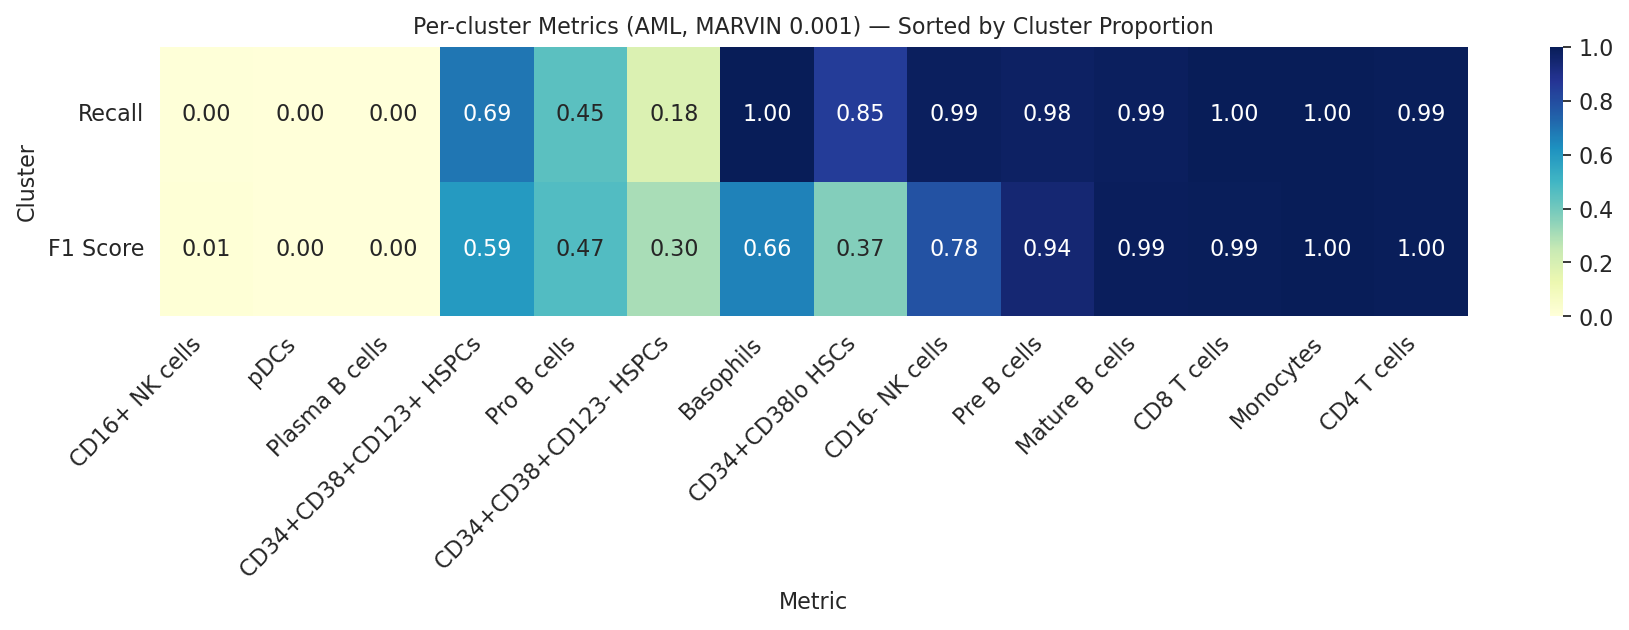

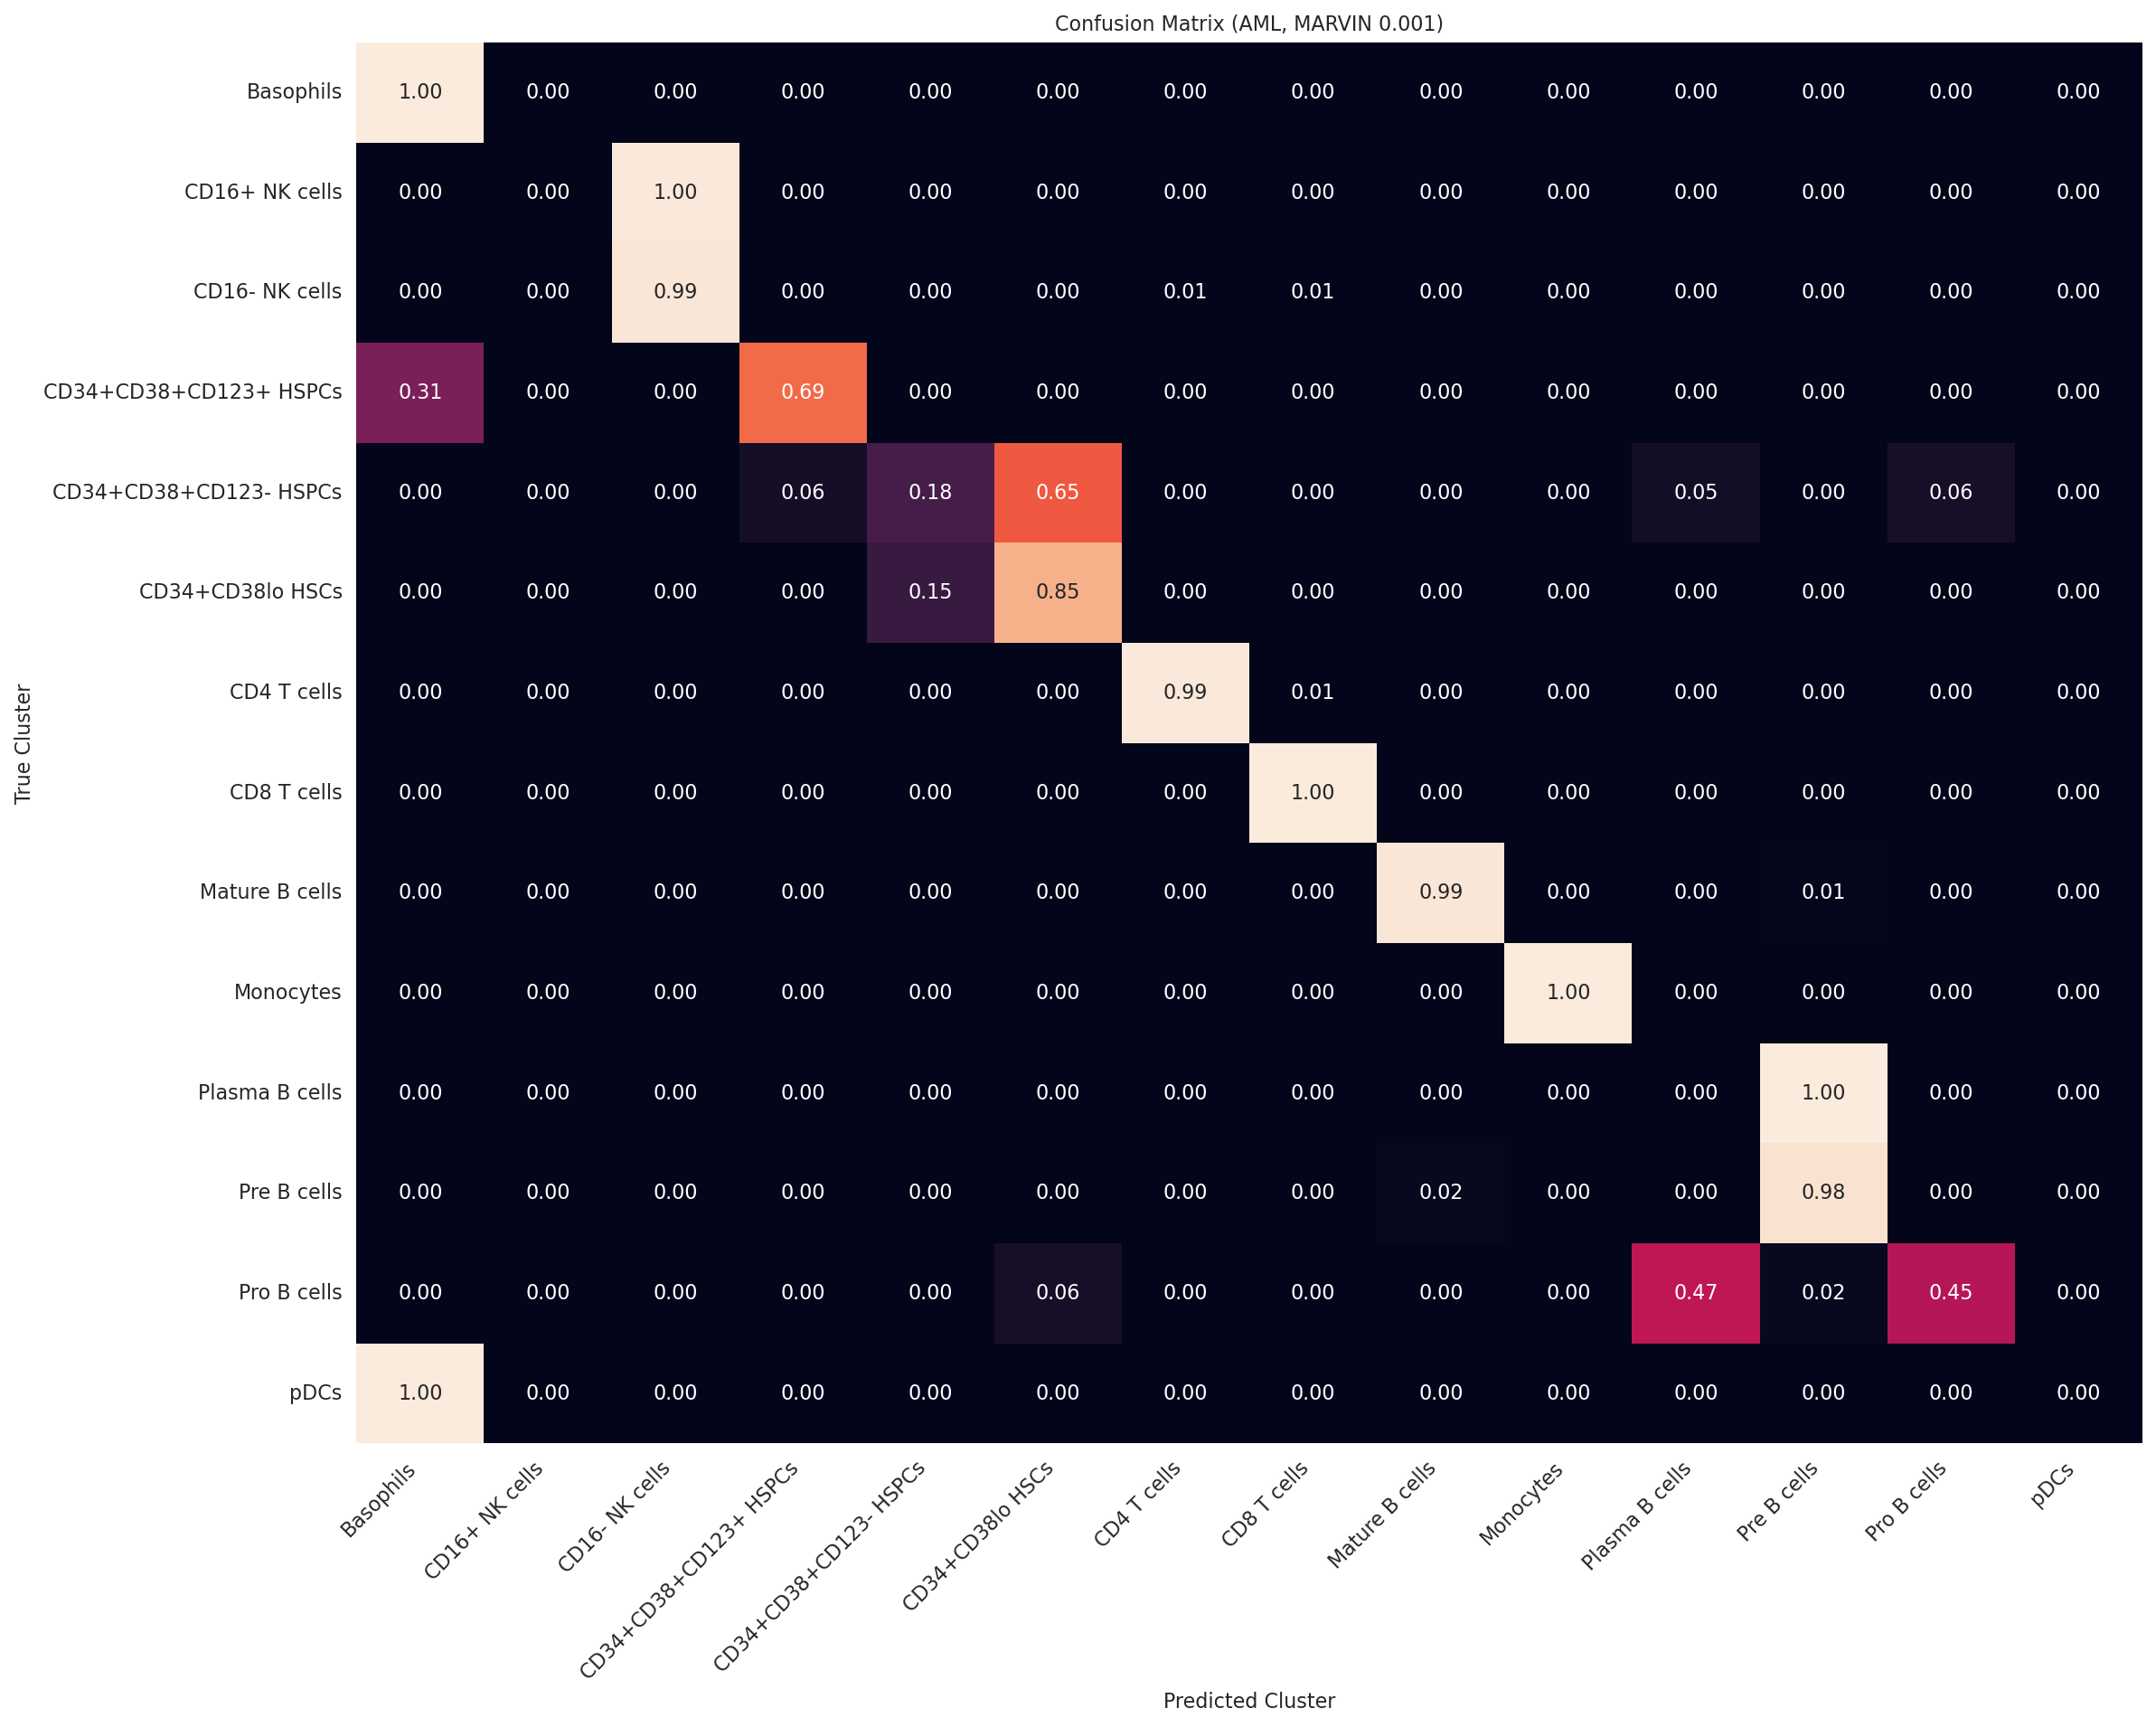

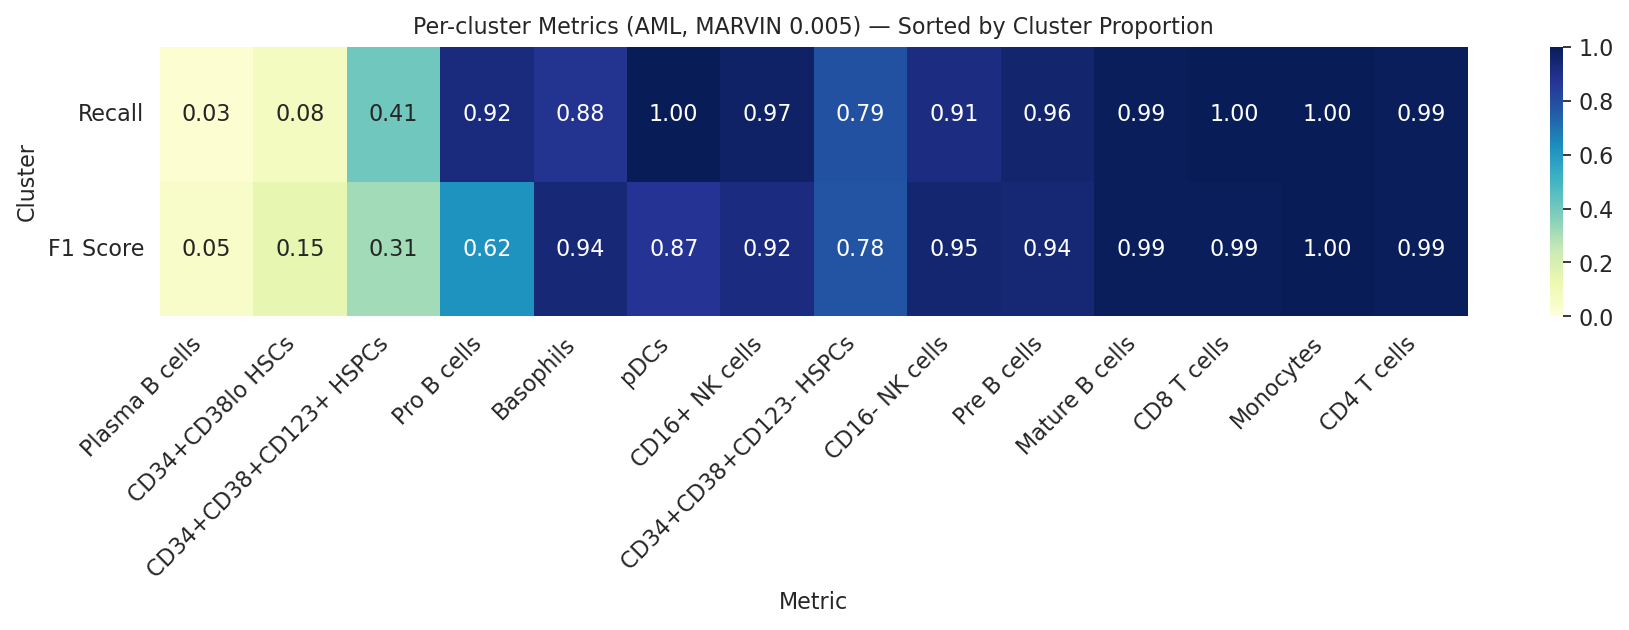

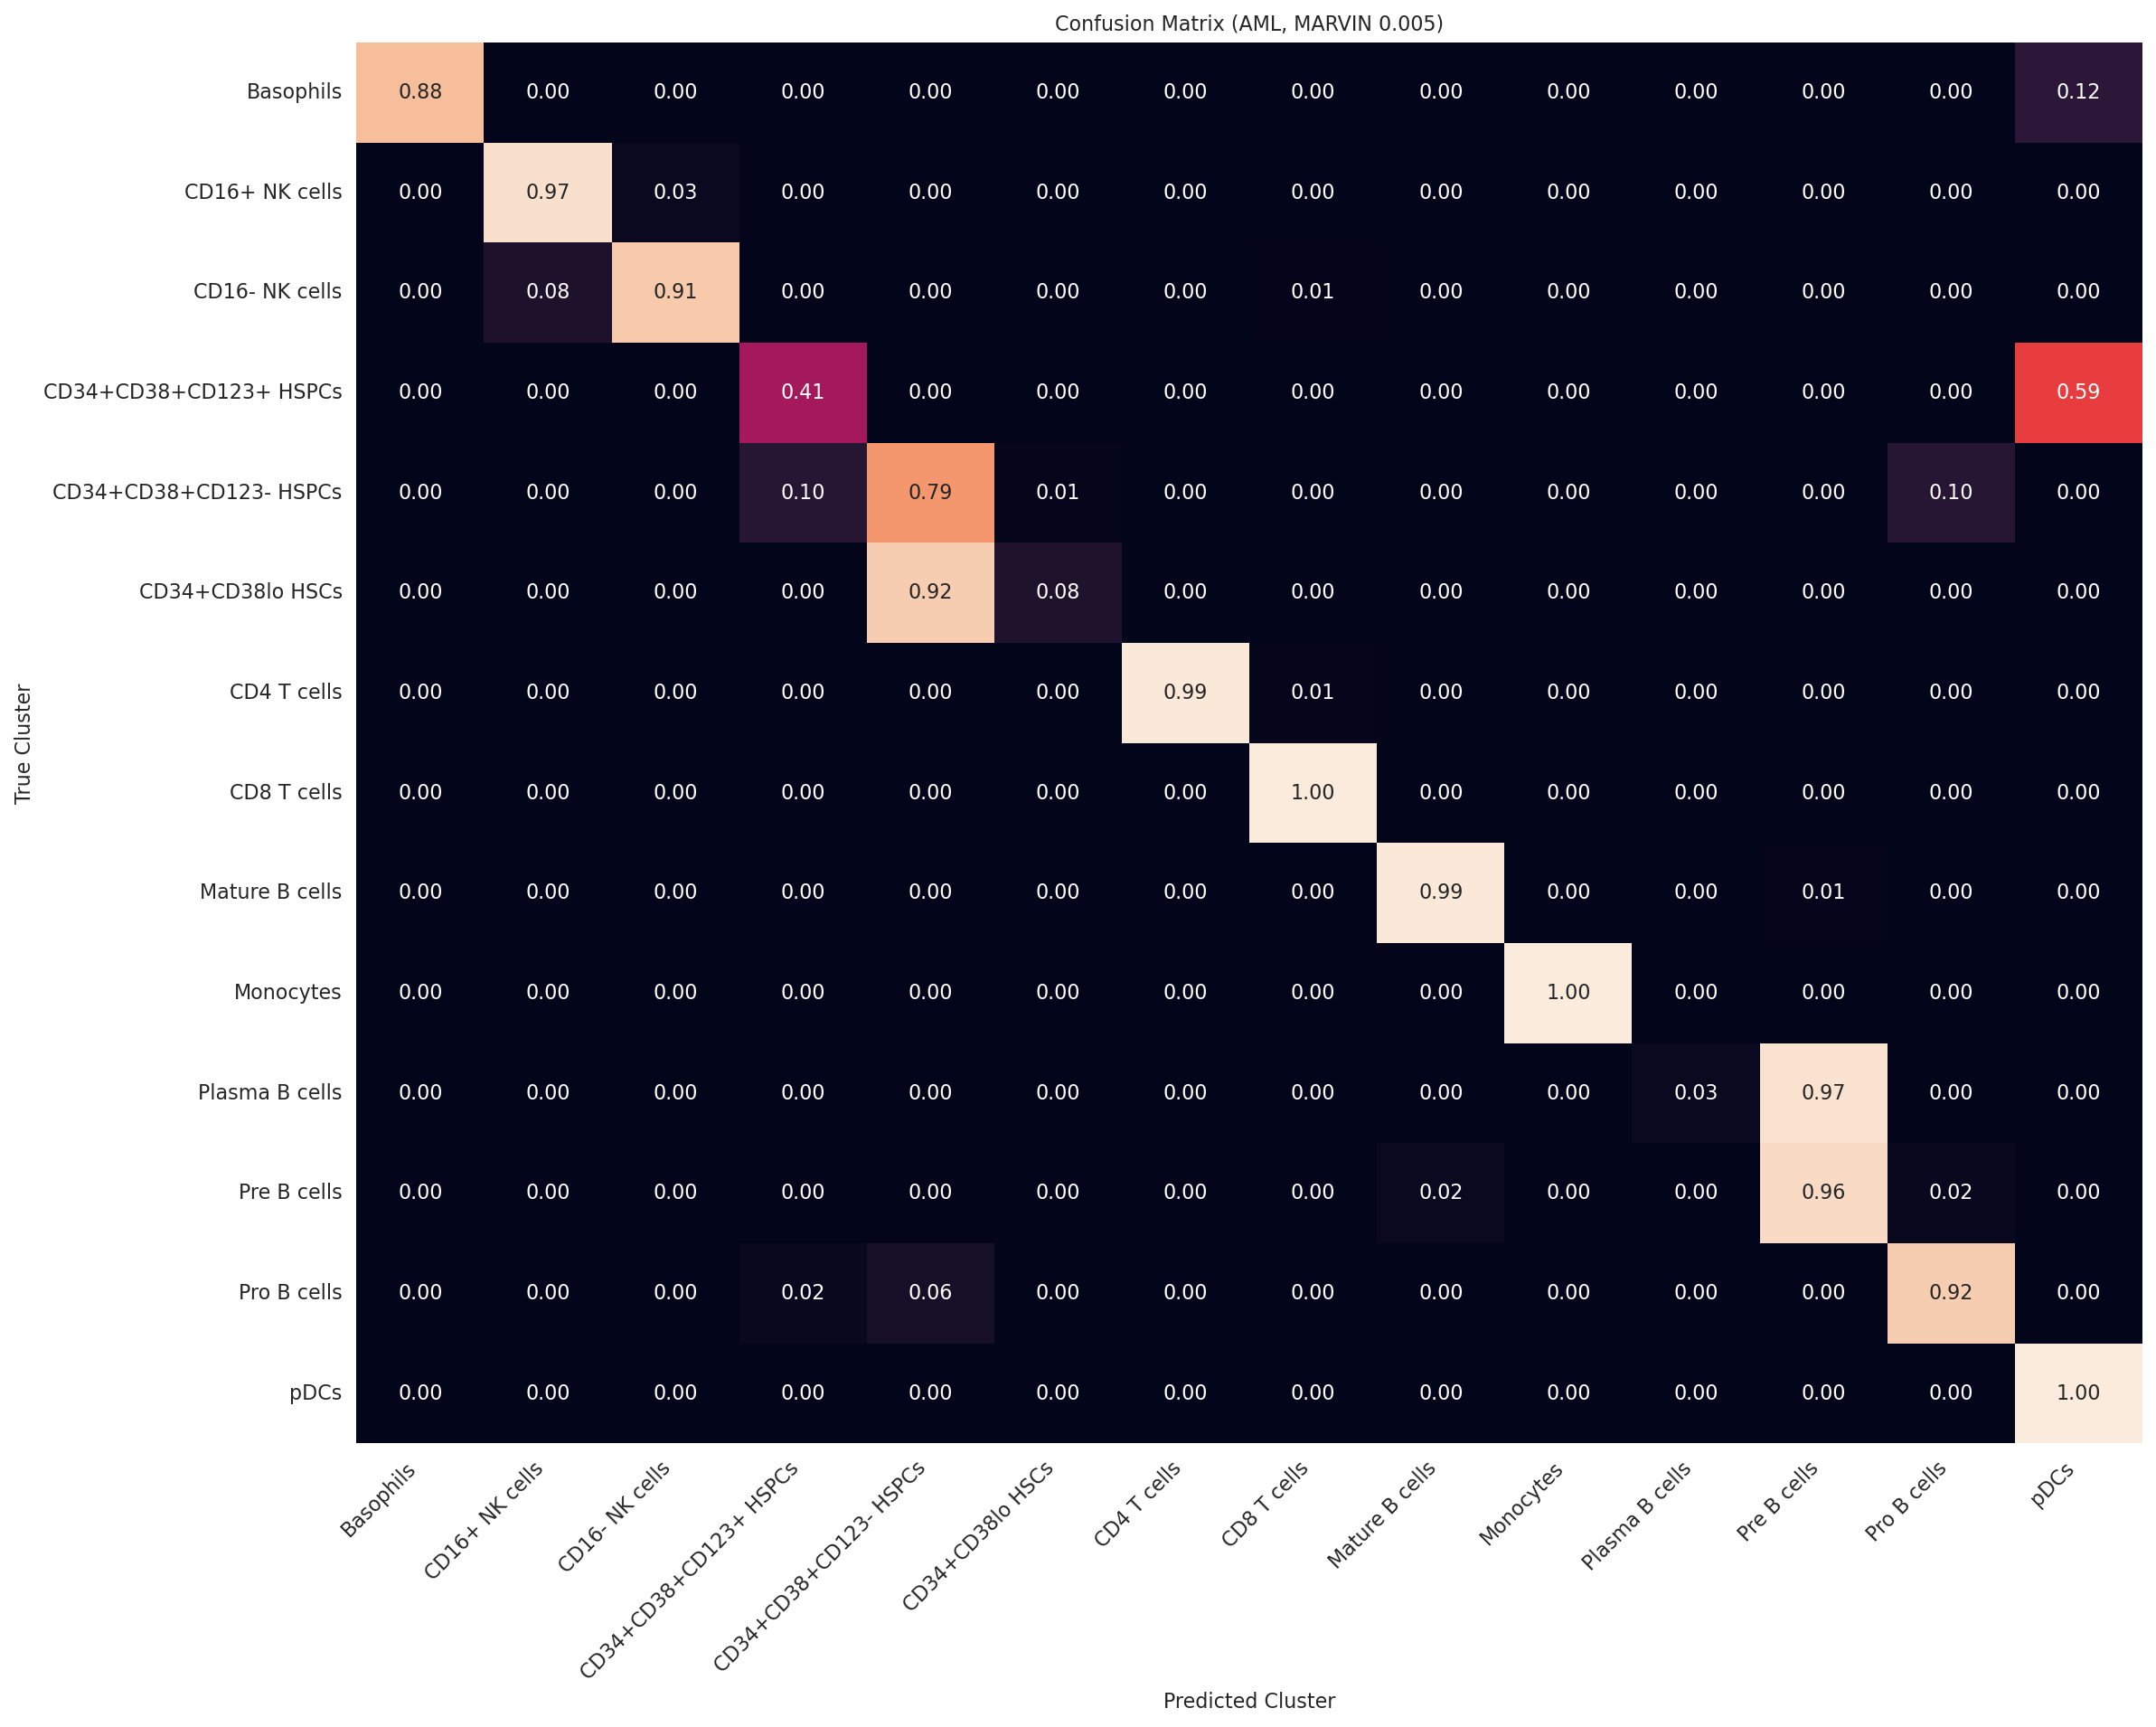

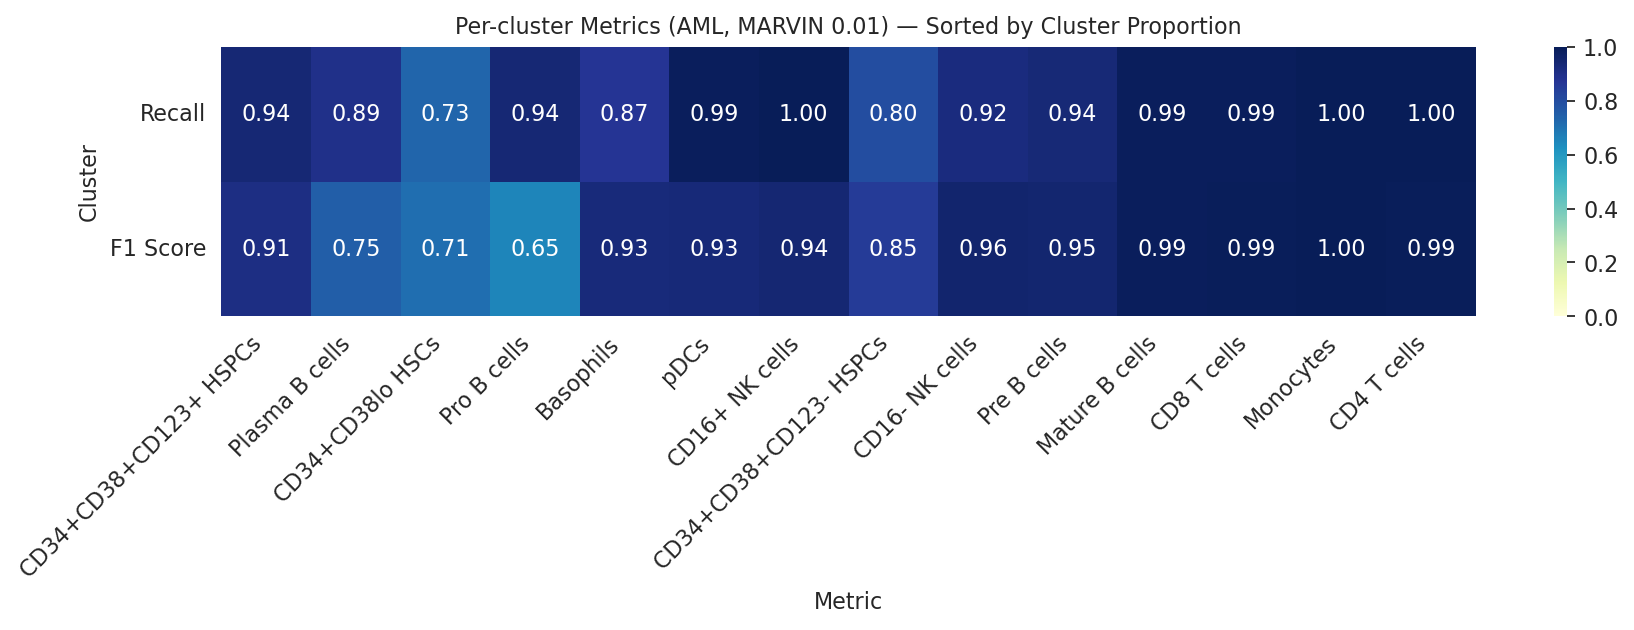

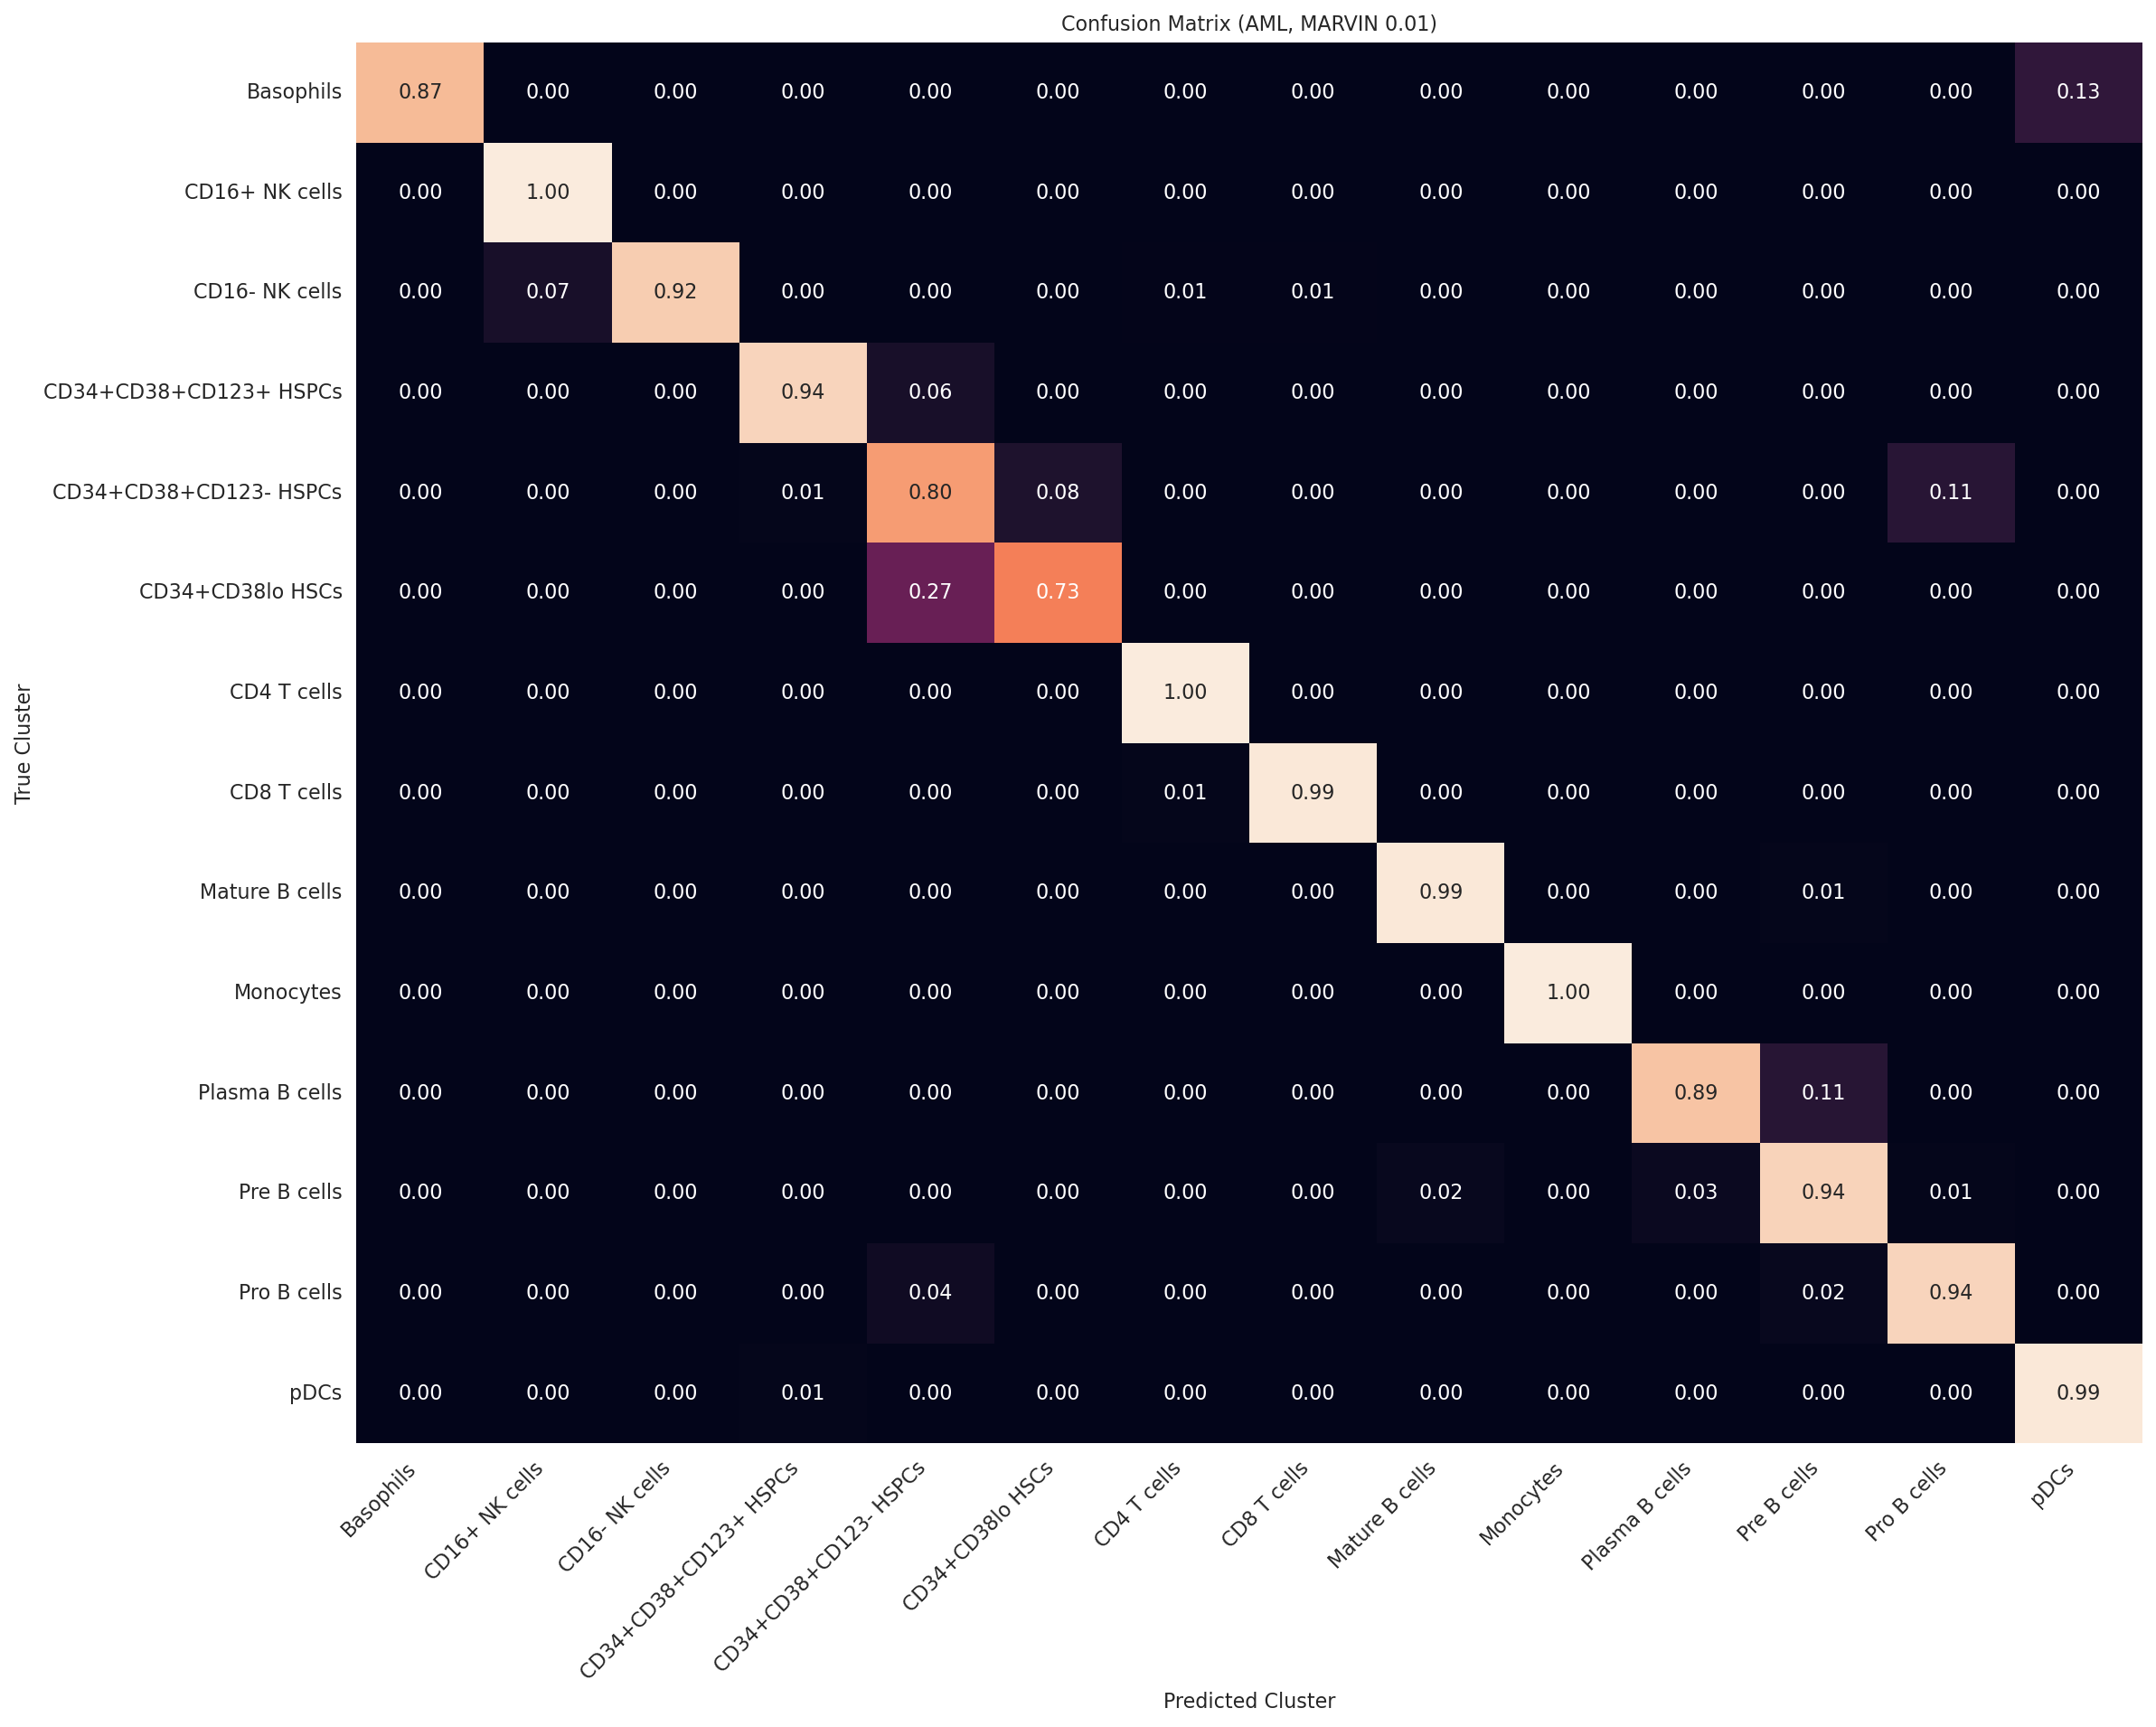

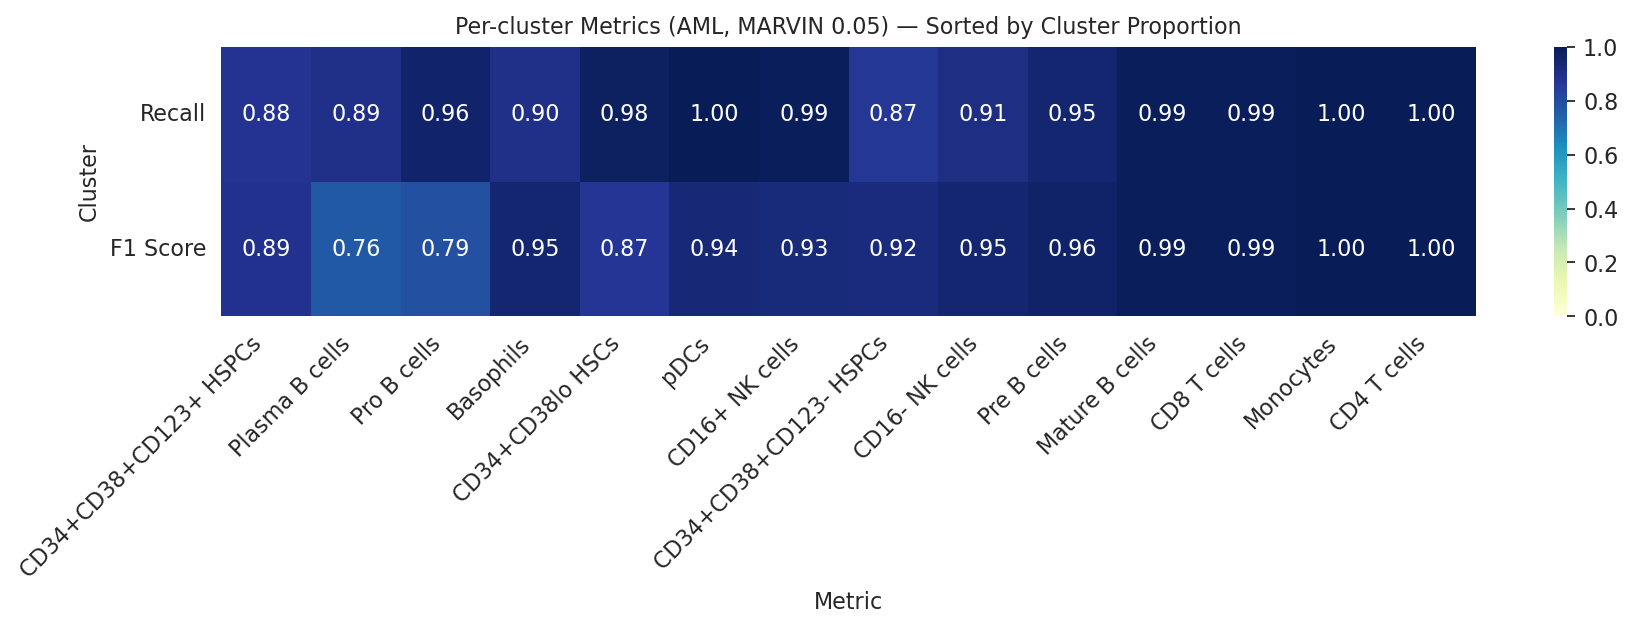

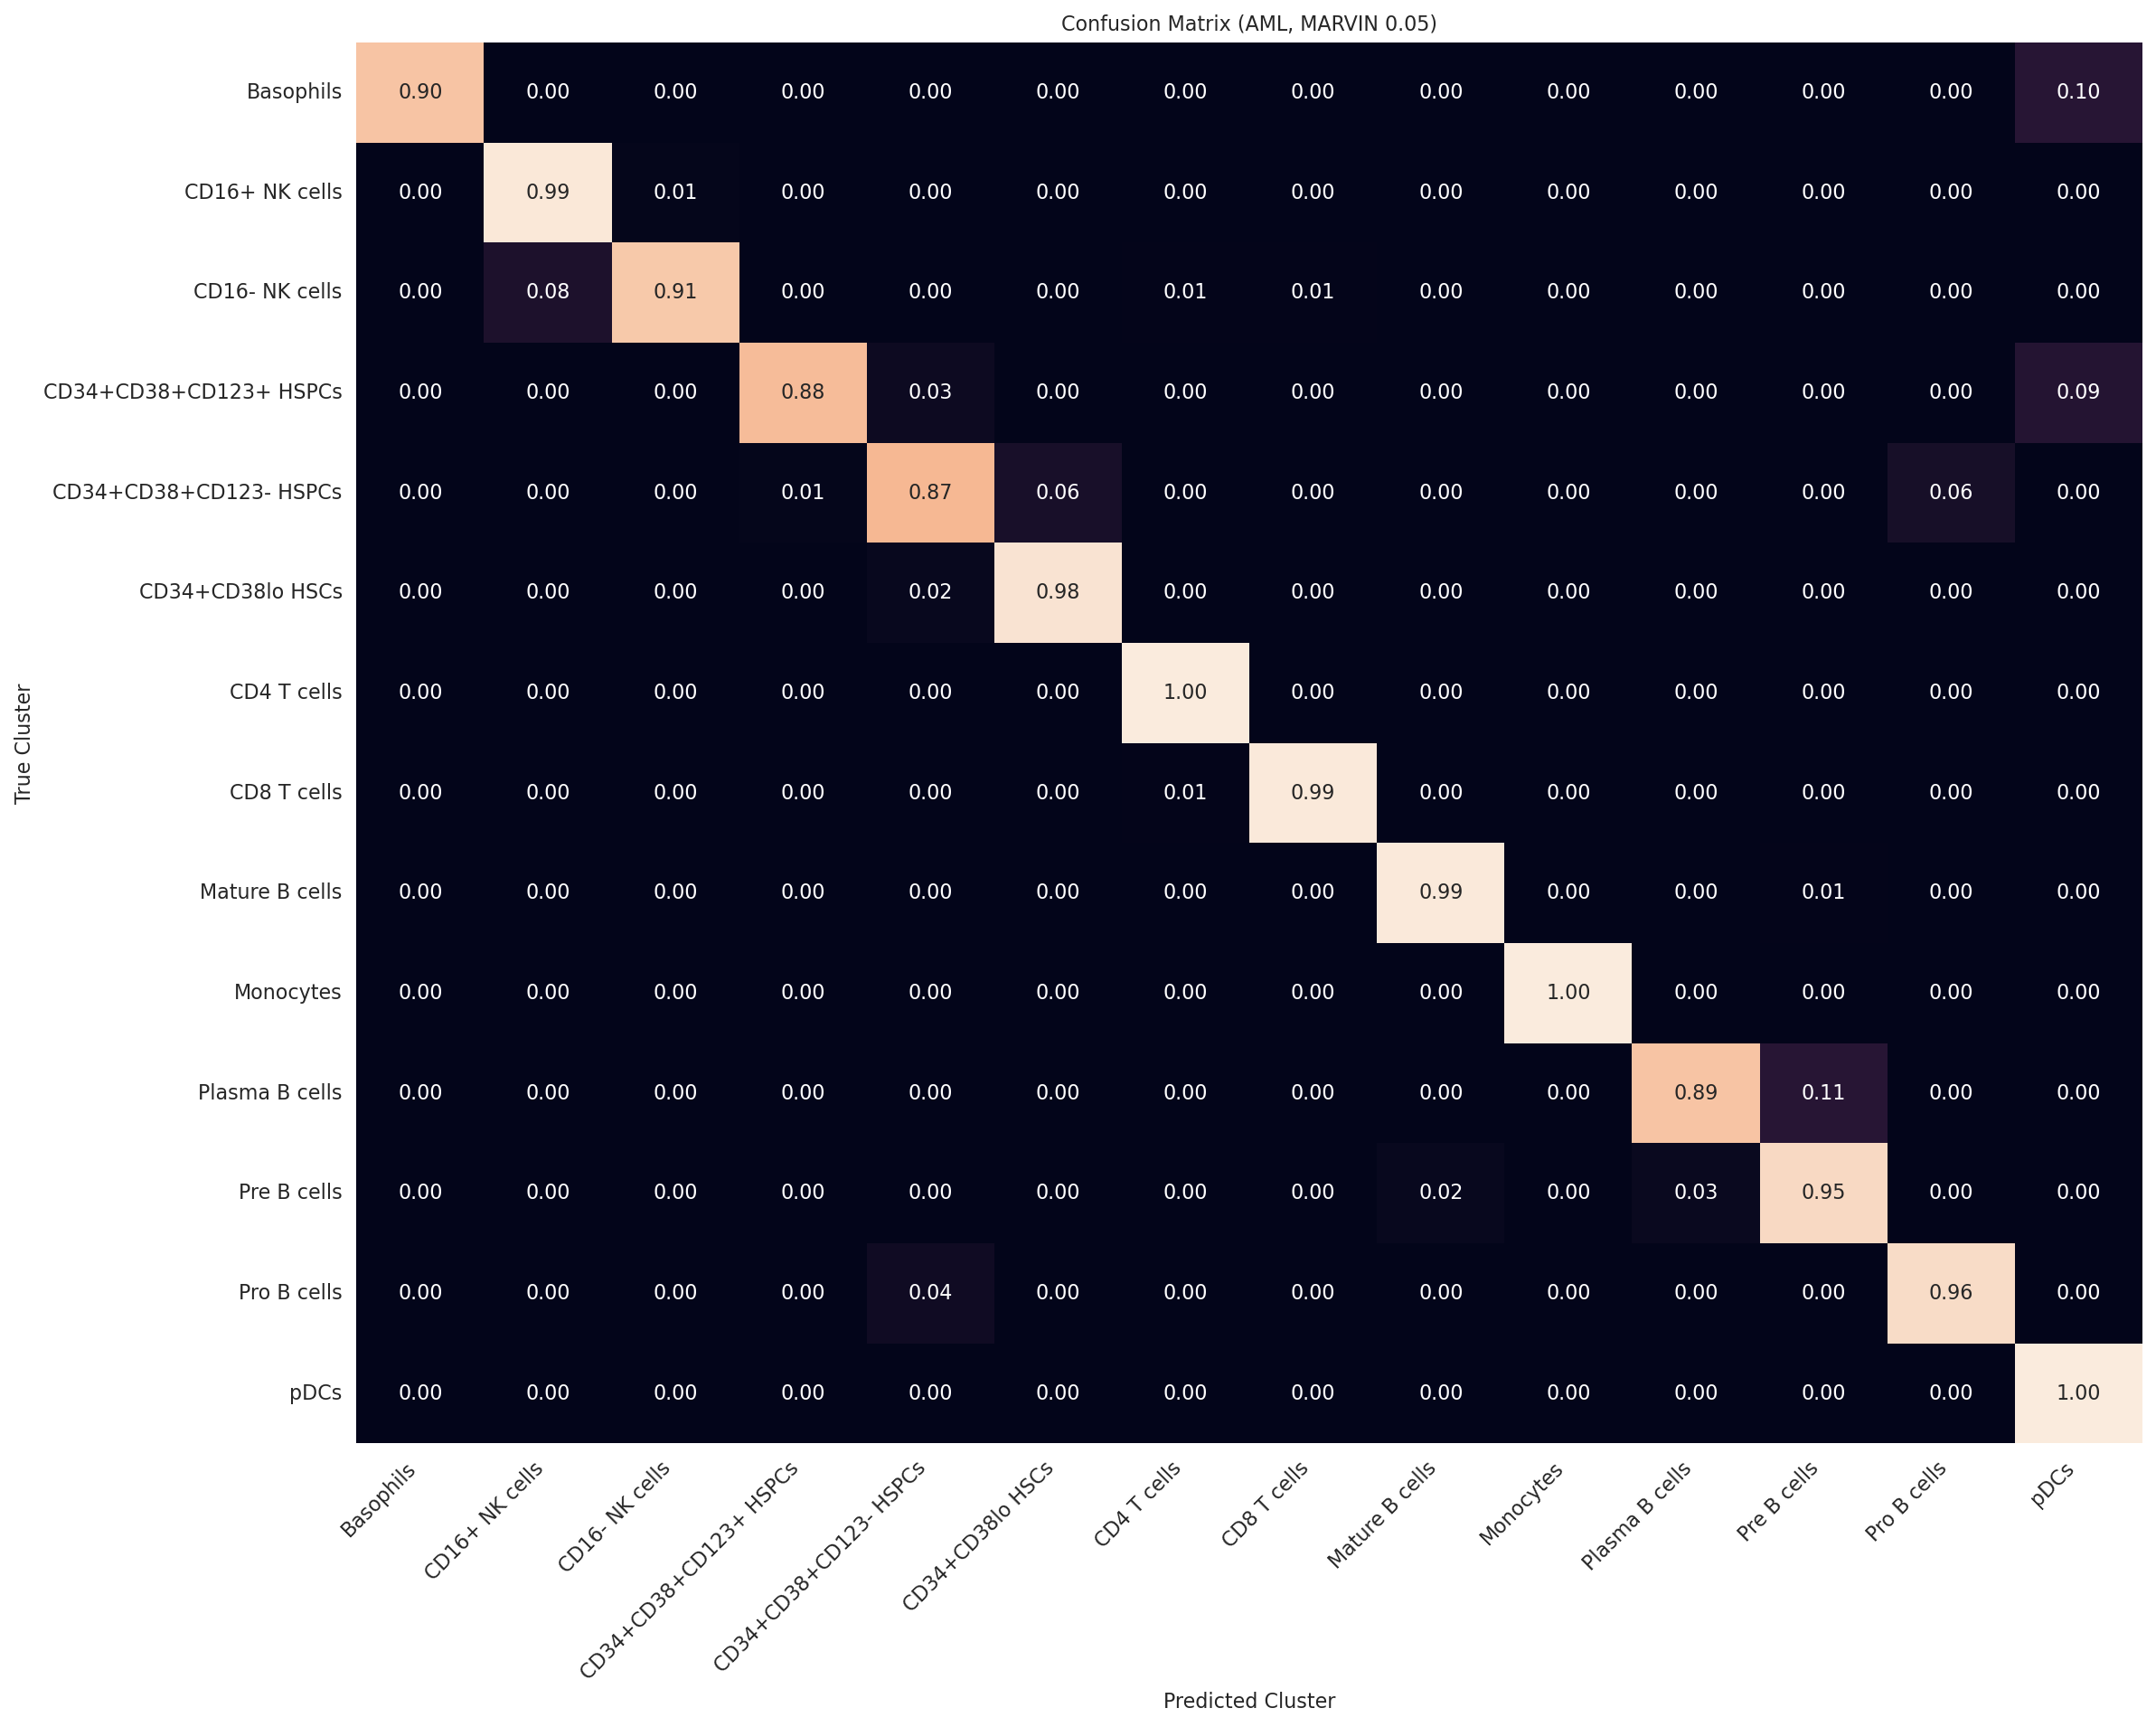

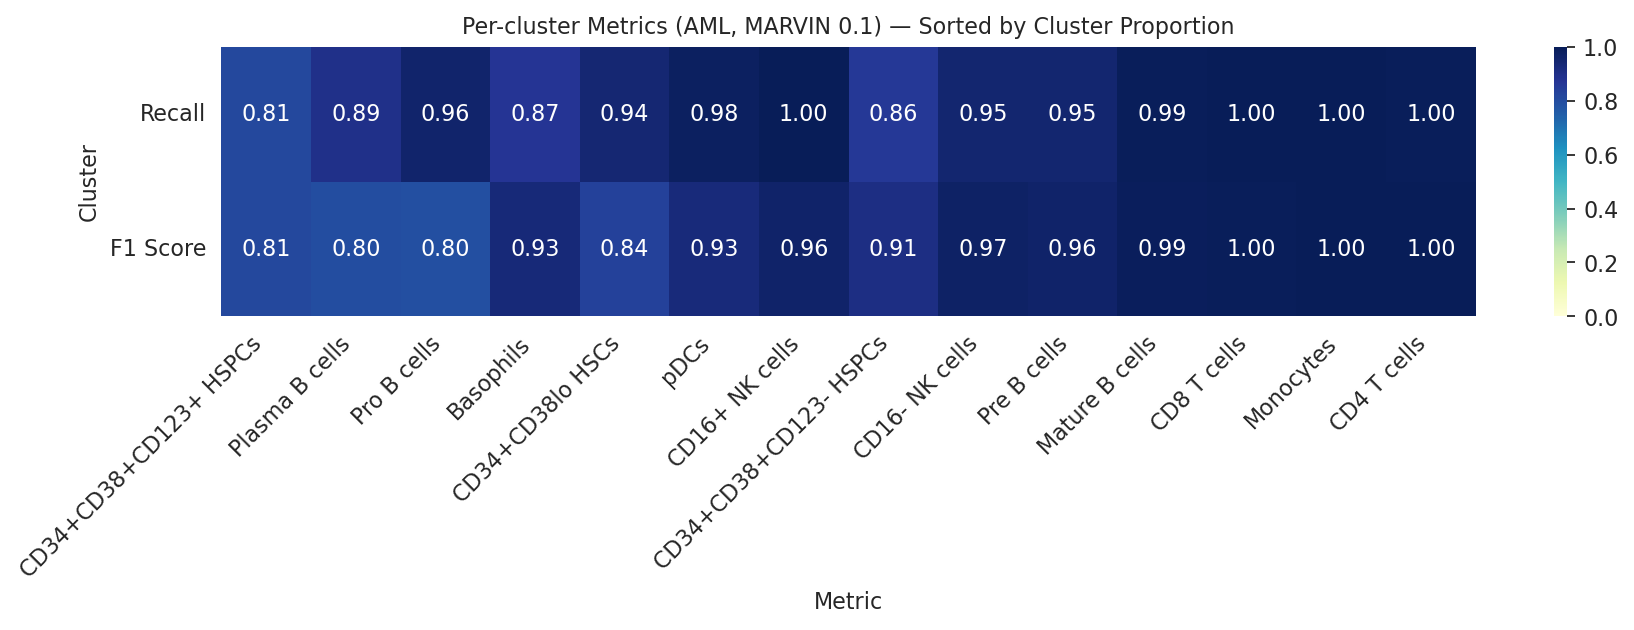

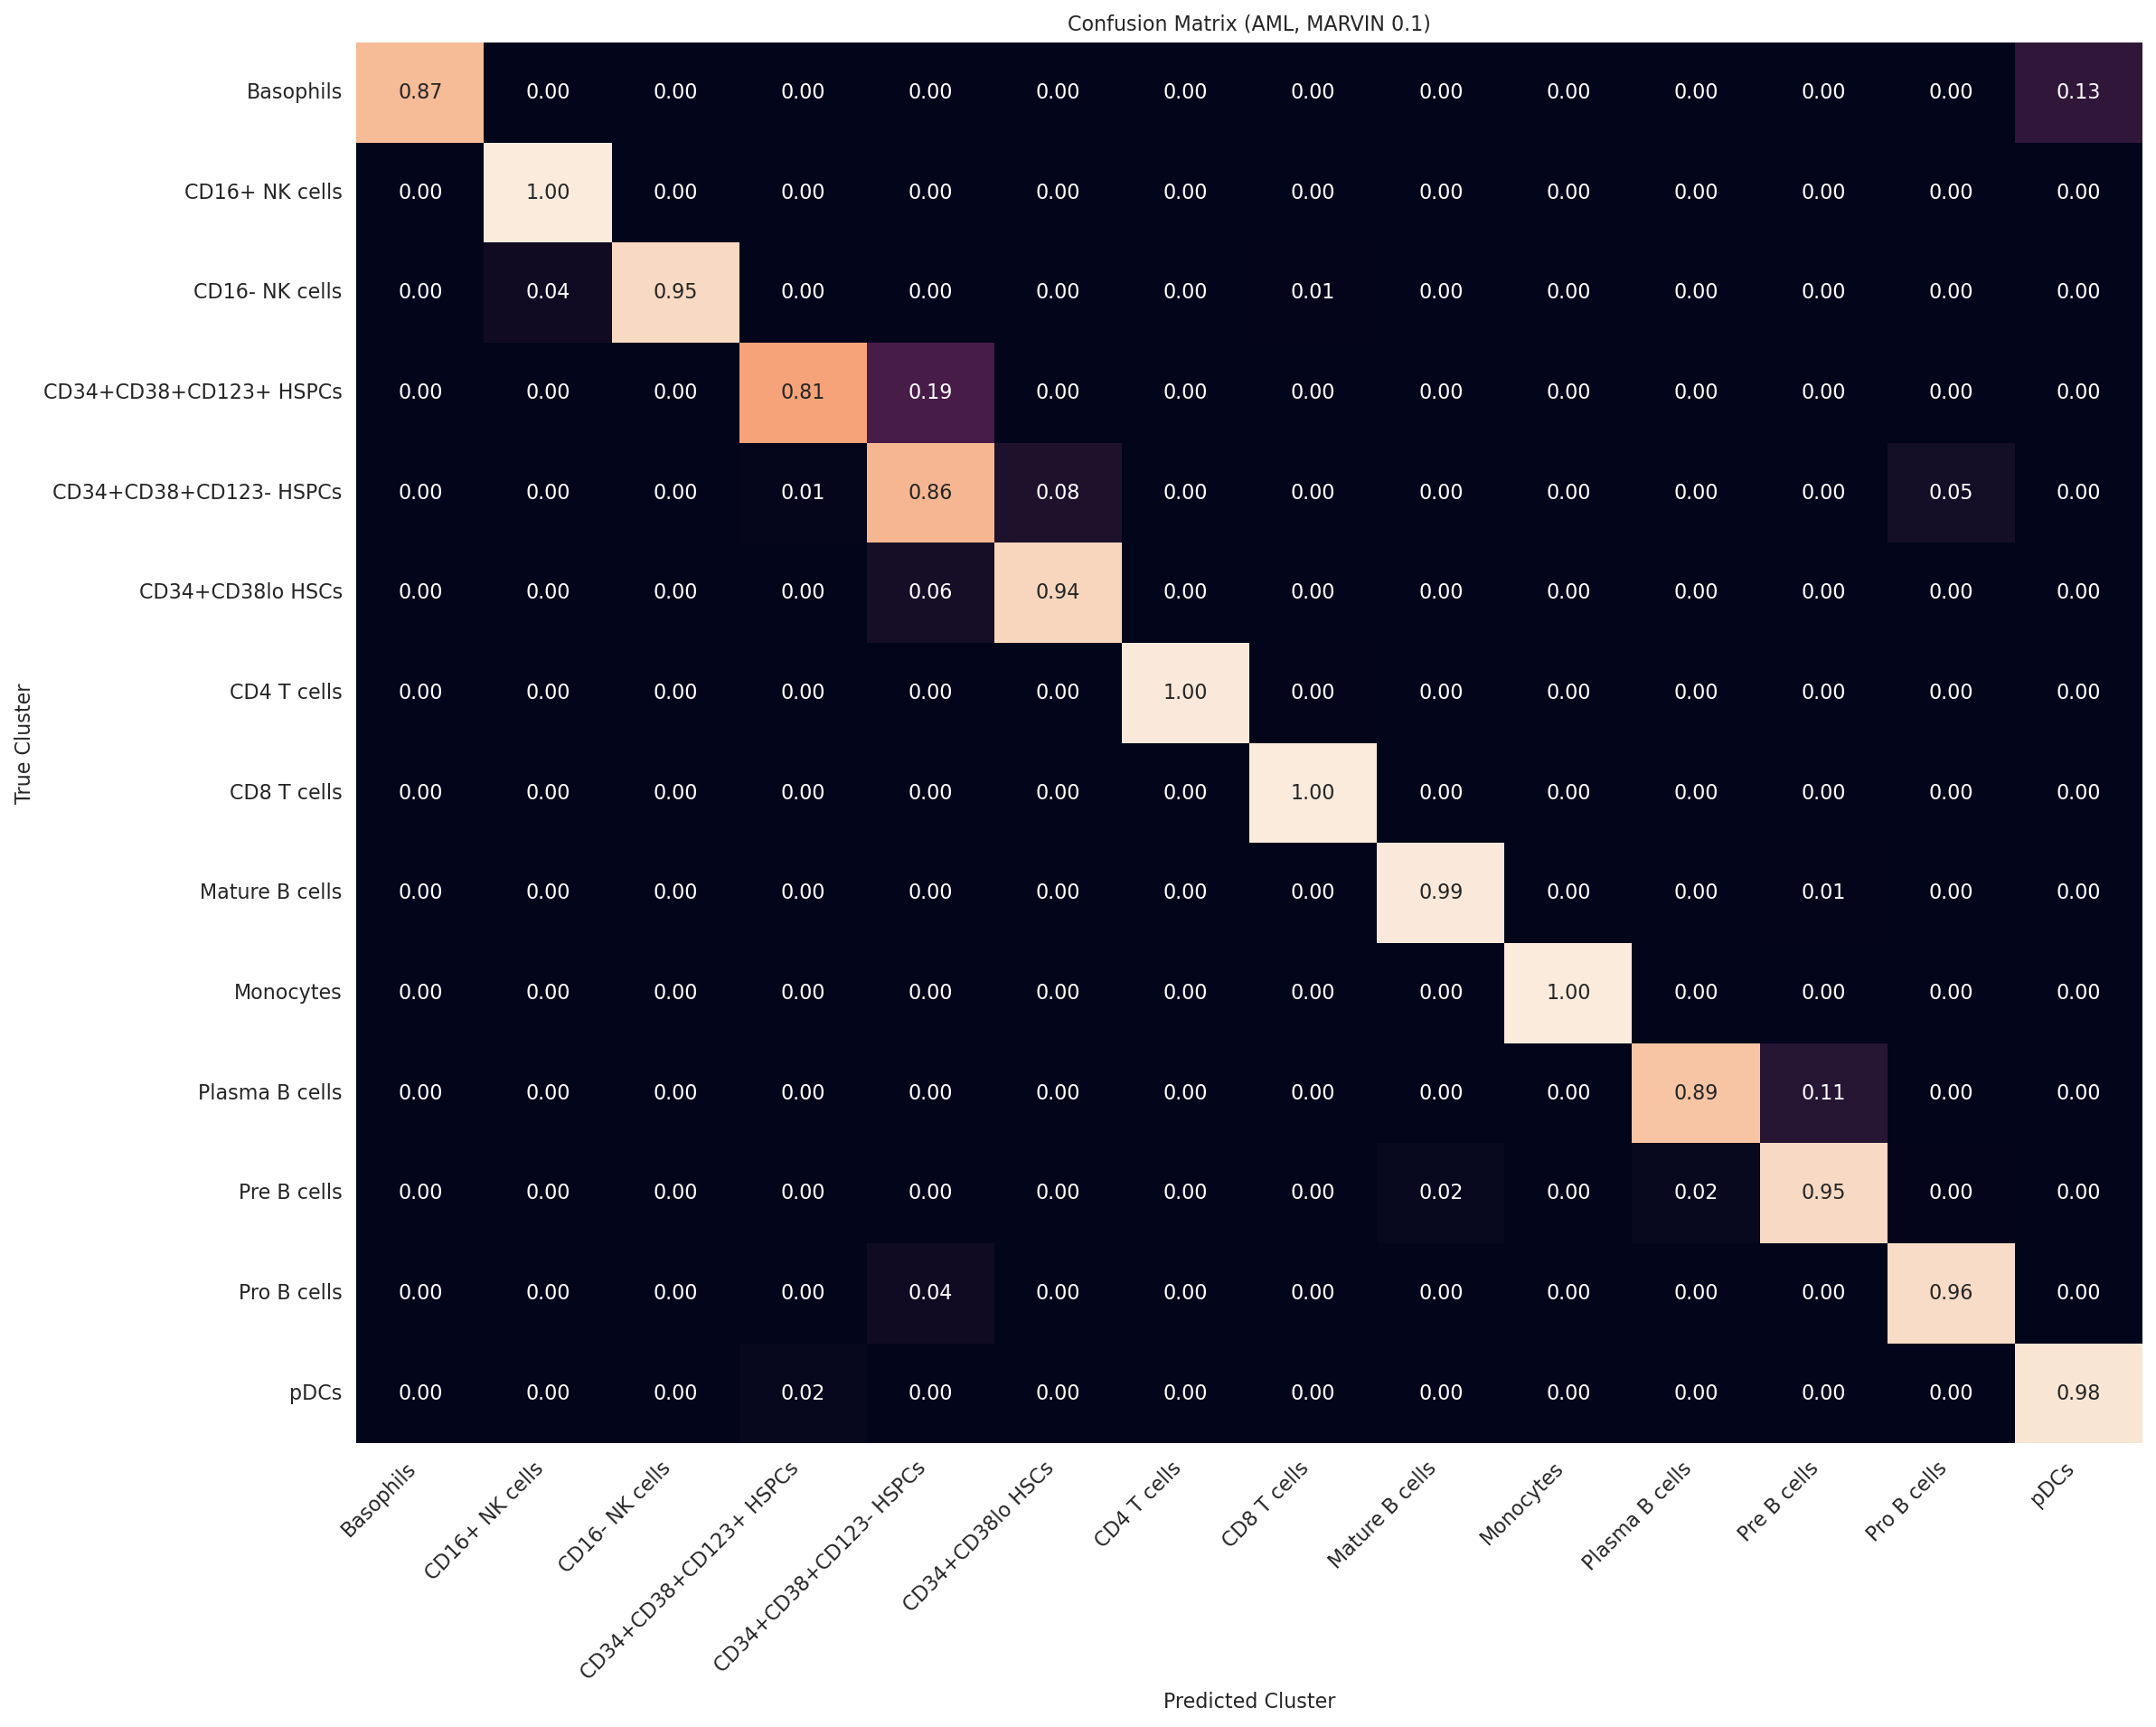

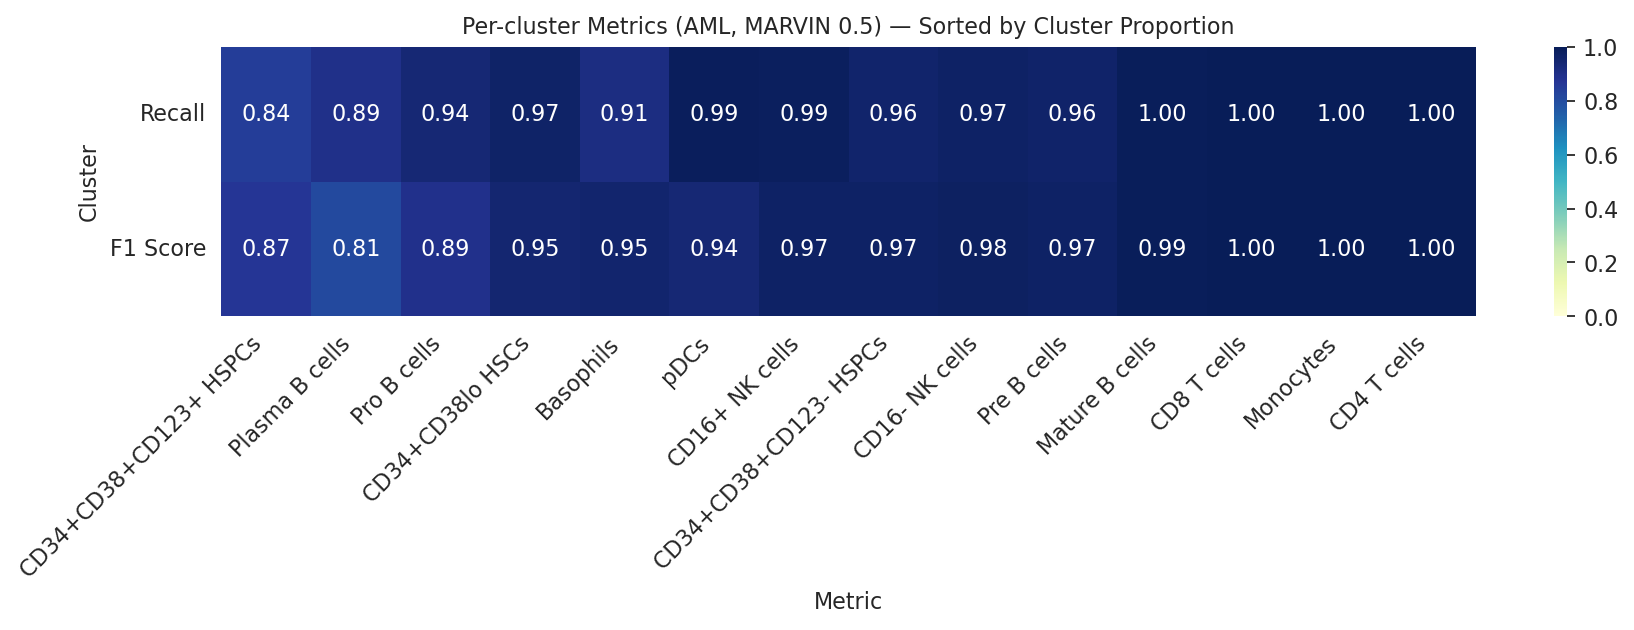

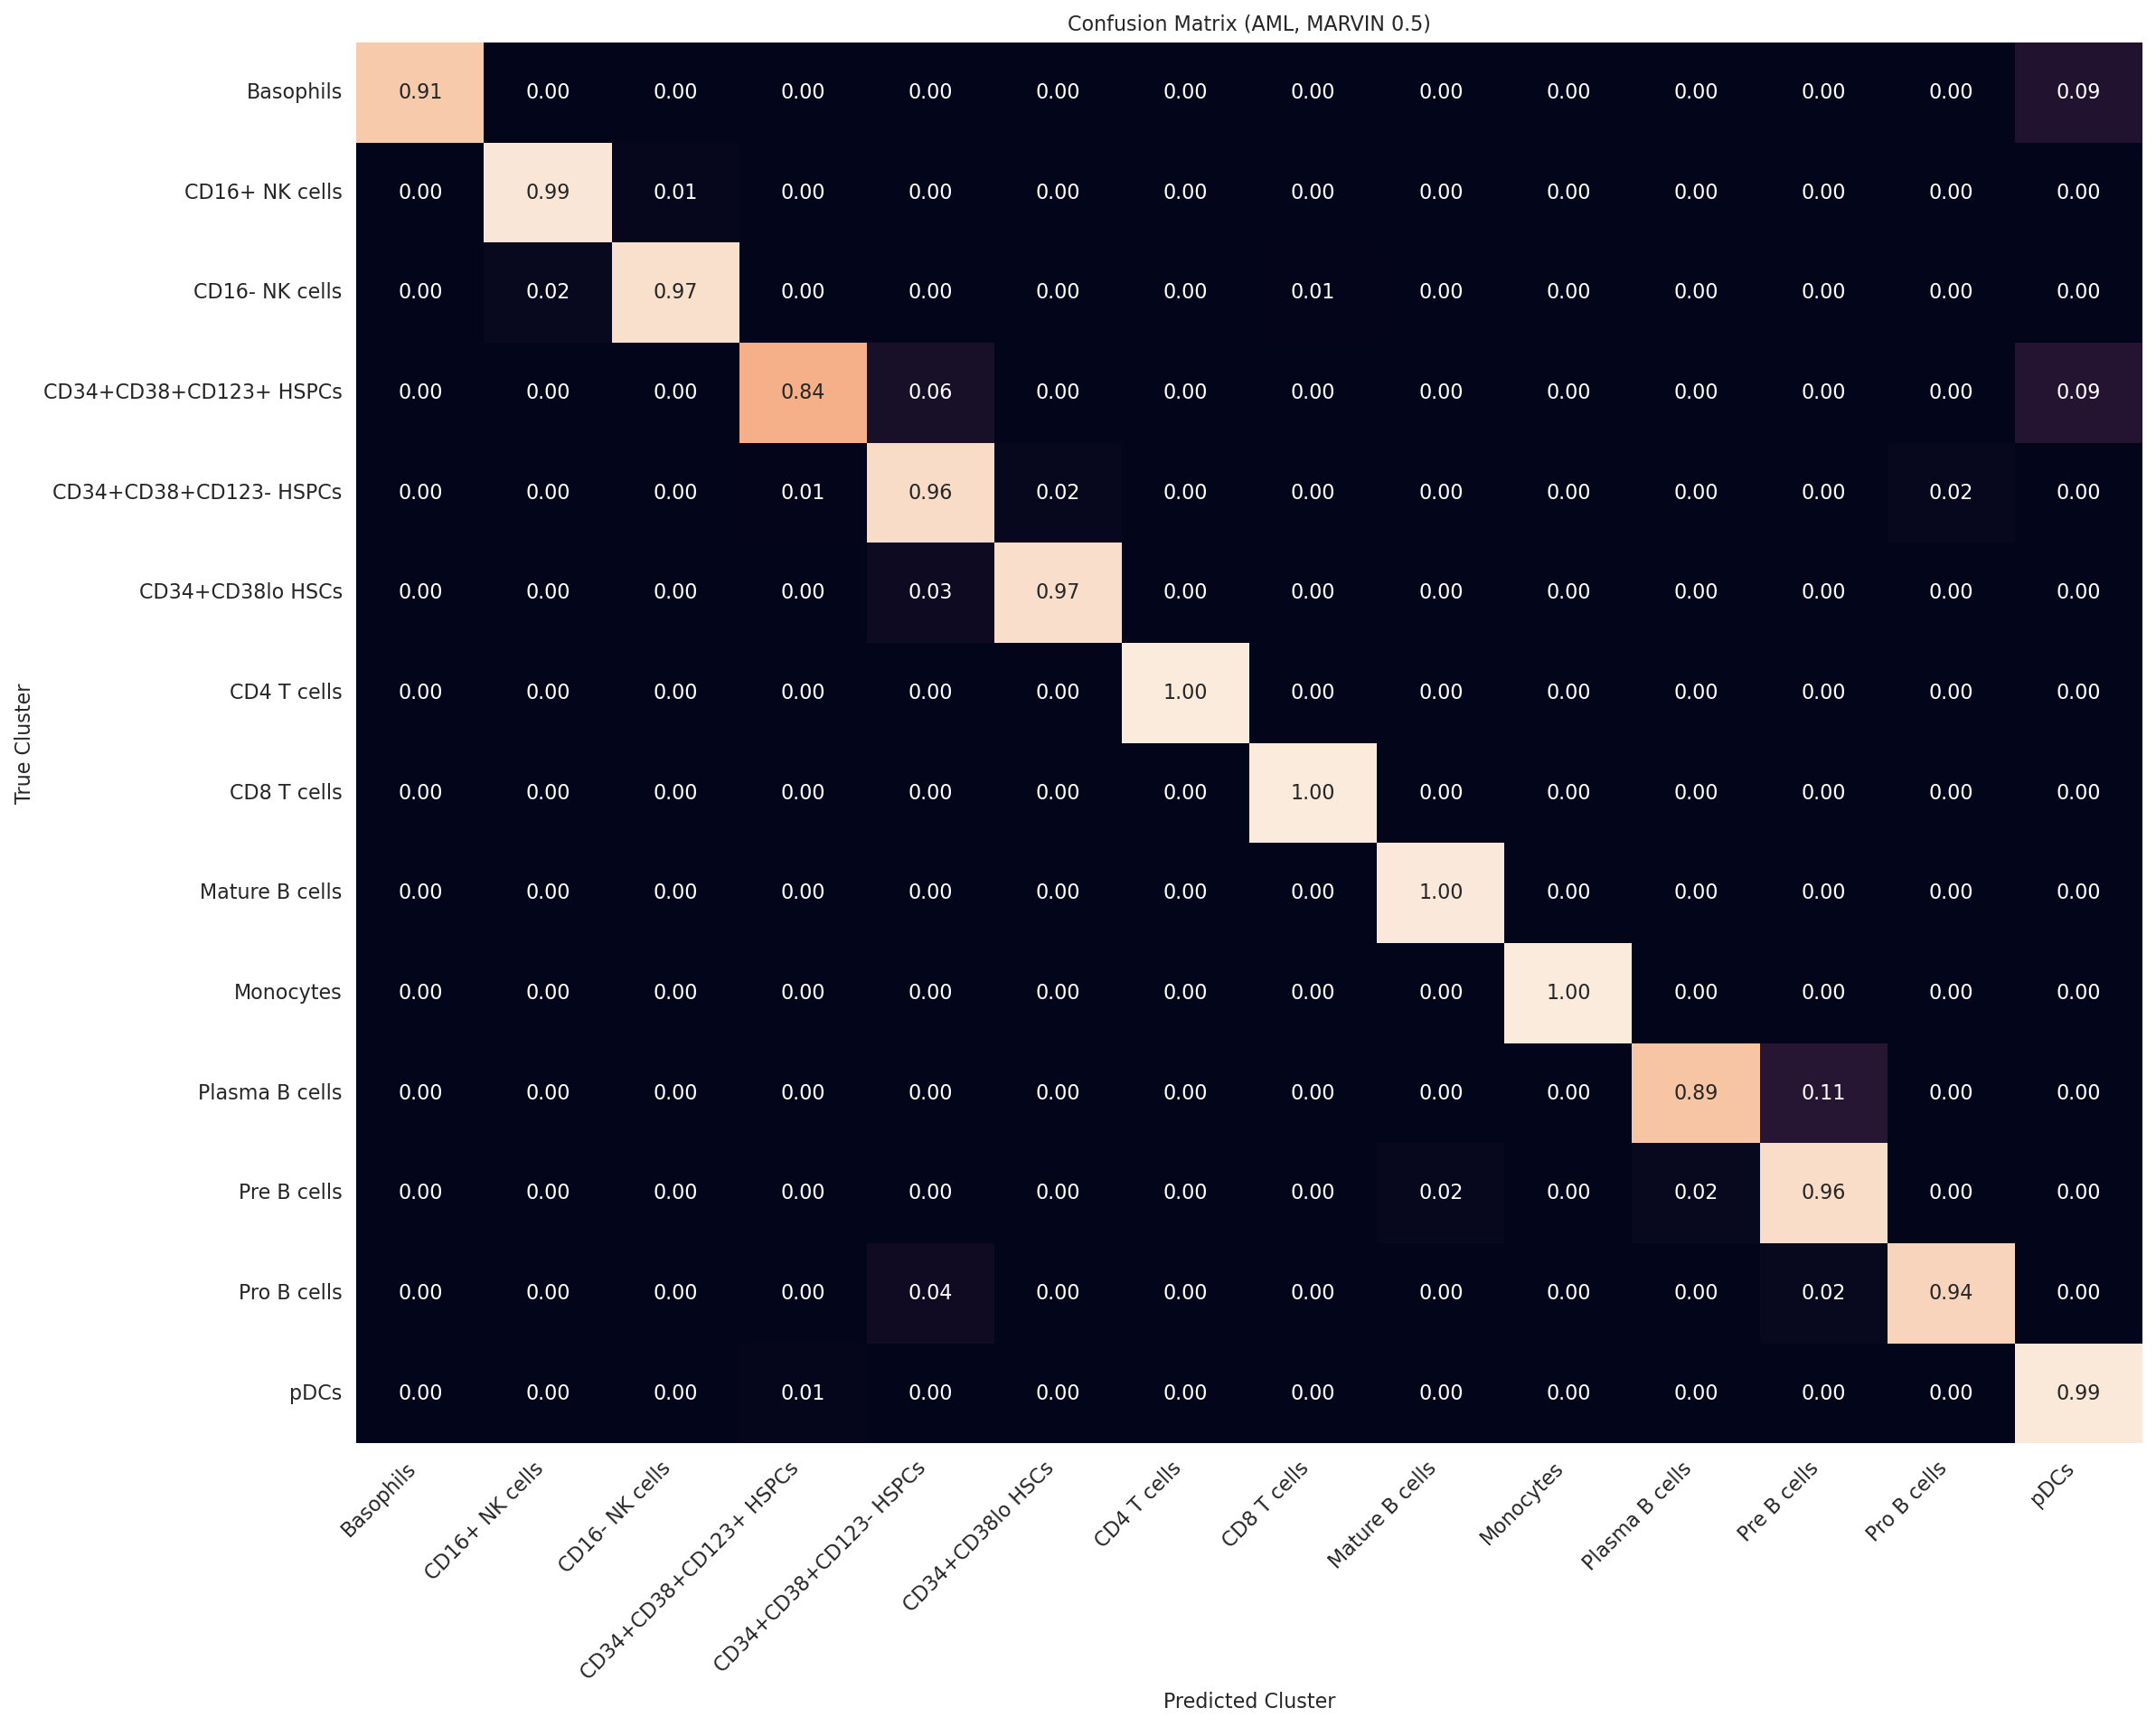

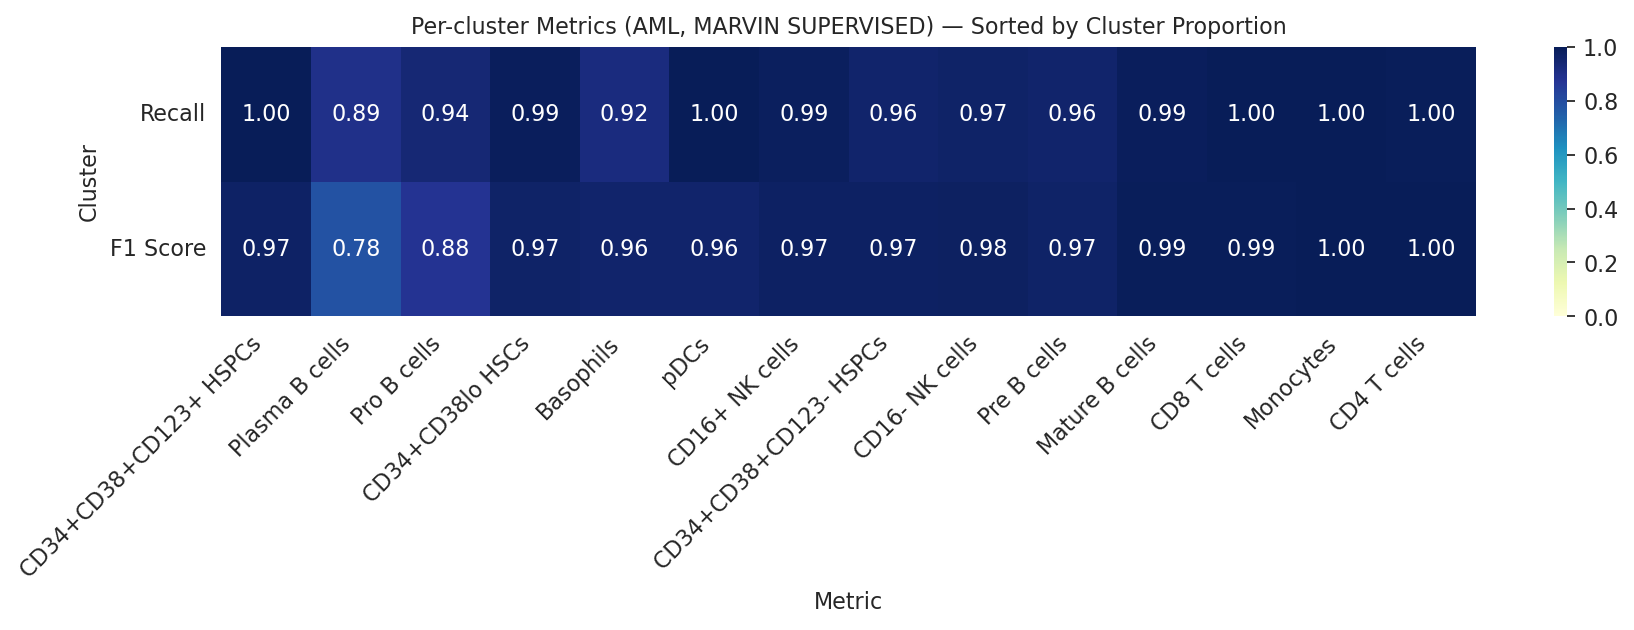

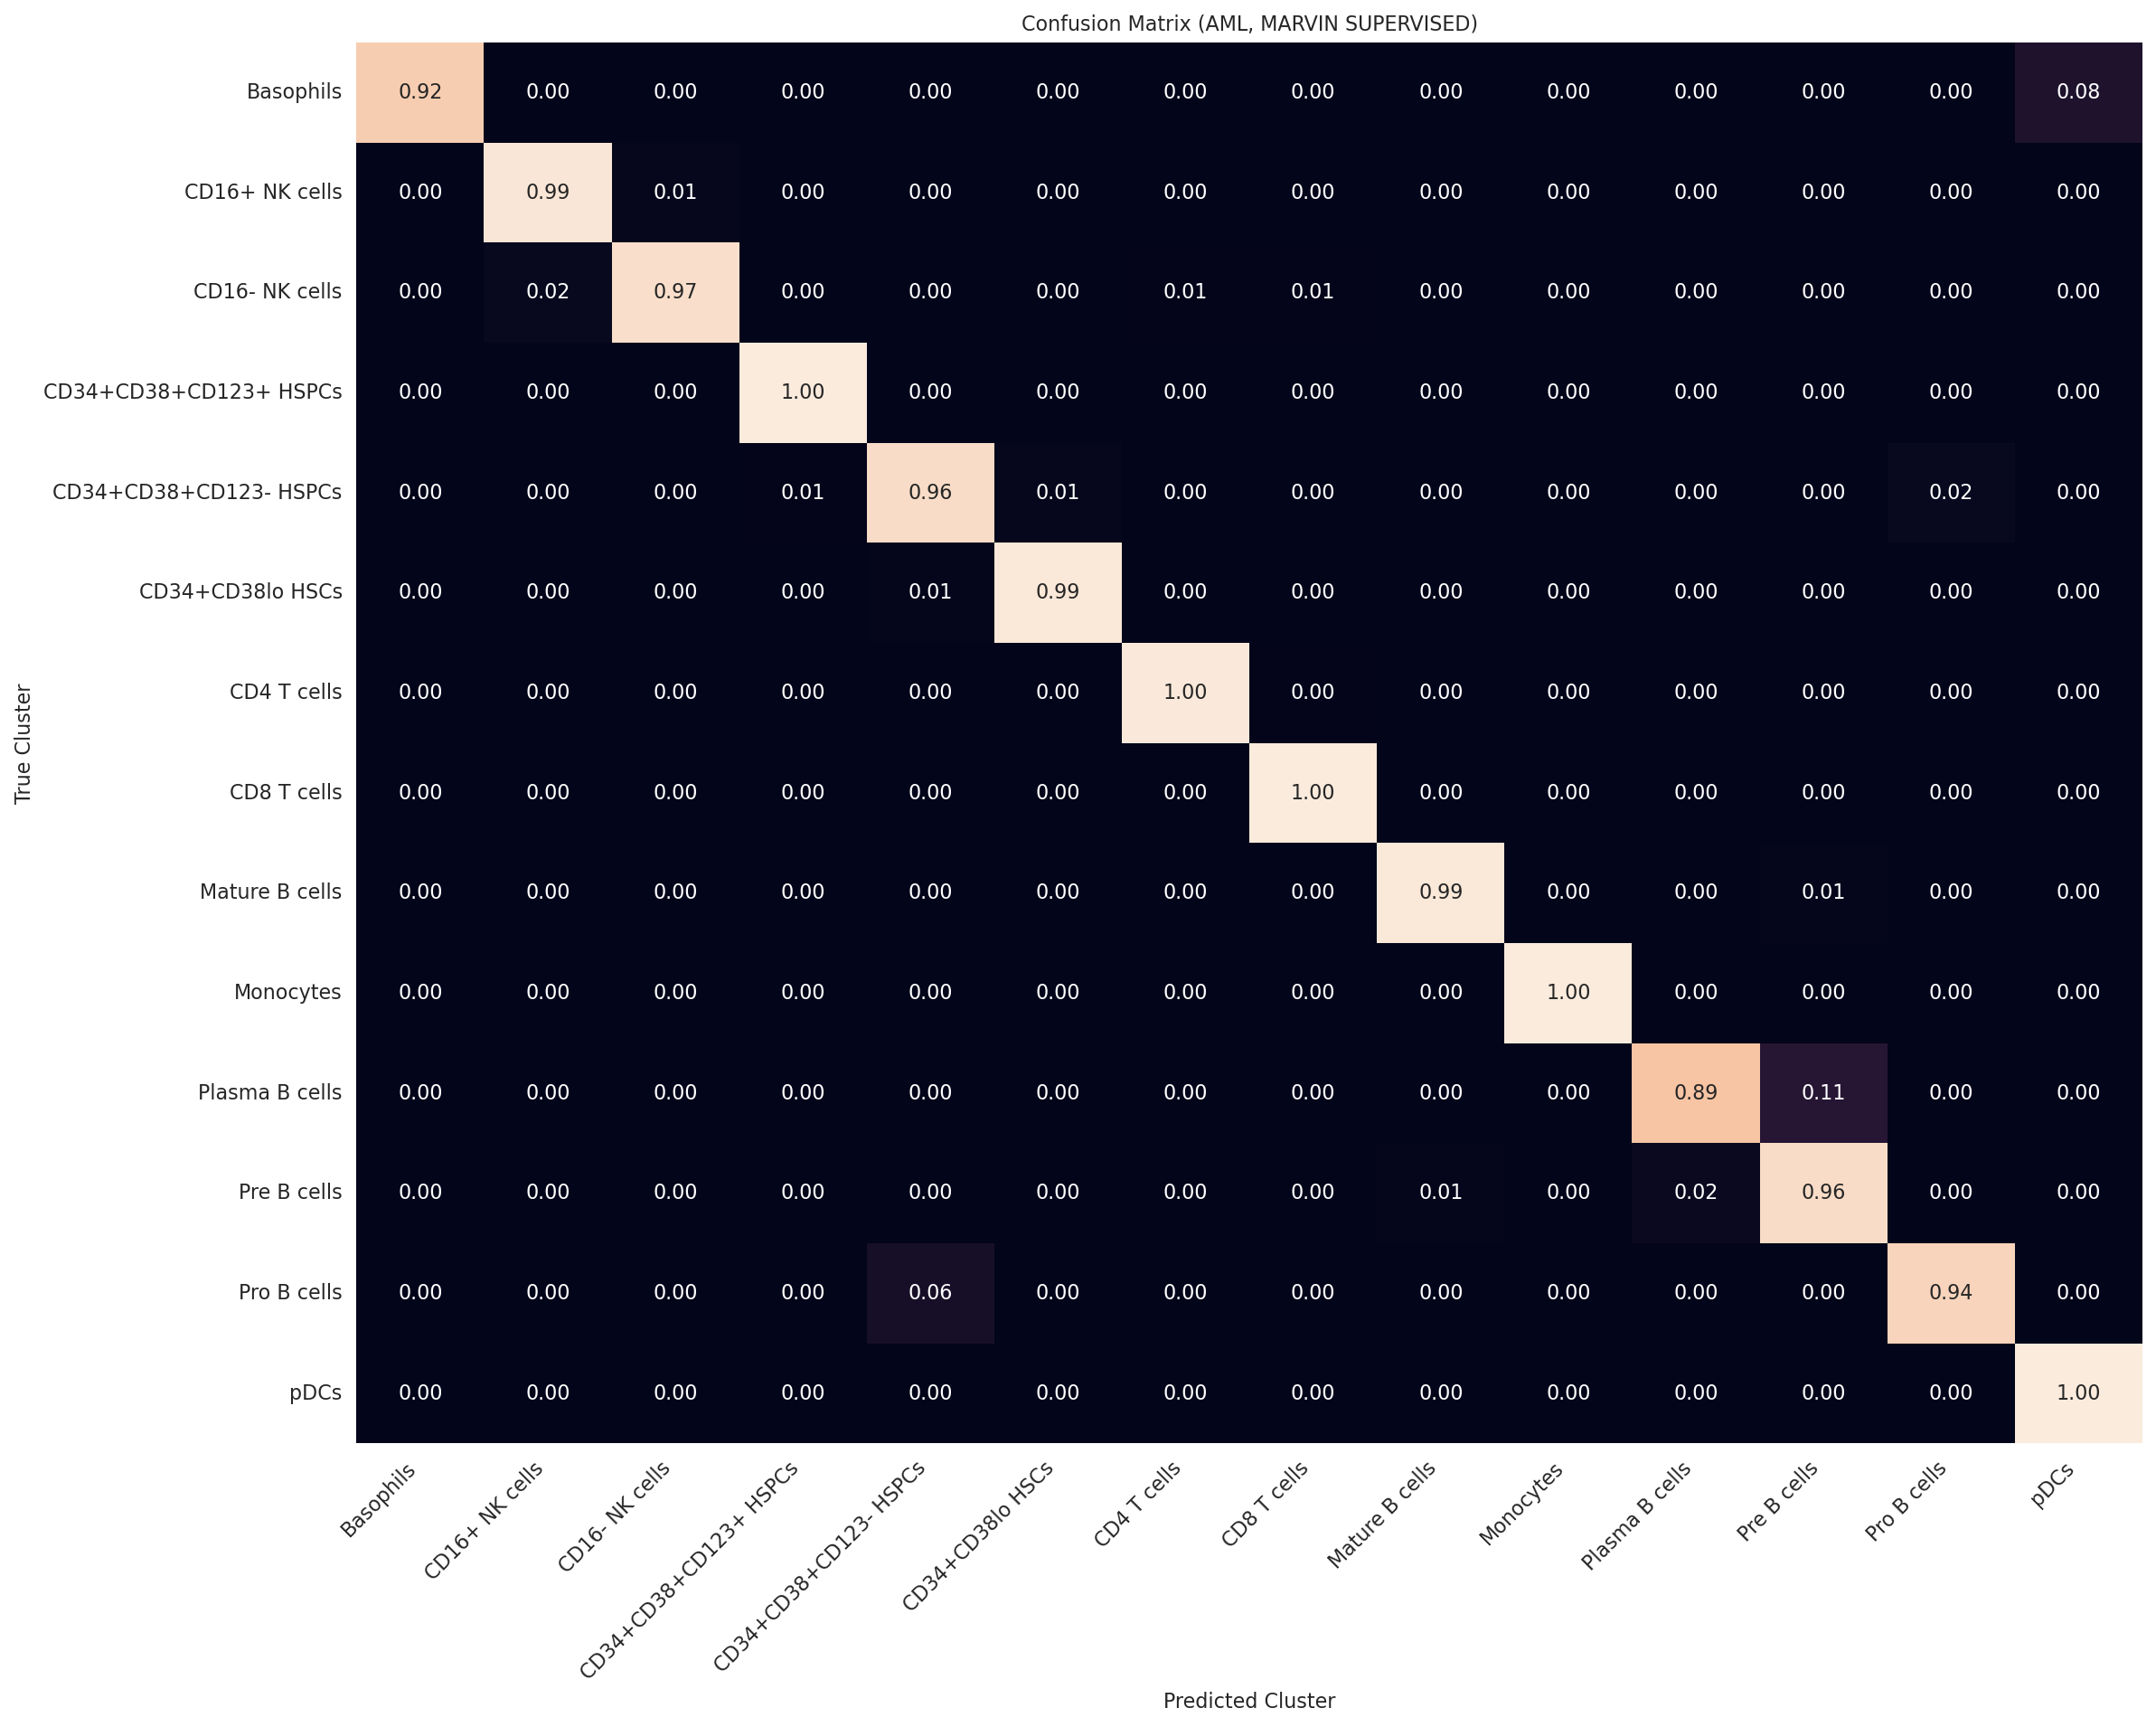

In [27]:
models = {
    'MARVIN 0.001': model0_1,
    'MARVIN 0.005': model05,
    'MARVIN 0.01': model1,
    'MARVIN 0.05': model5,
    'MARVIN 0.1': model10,
    'MARVIN 0.5': model50,
    'MARVIN SUPERVISED': model
}
results = {}

for model_name, mymodel in models.items():
    balanced_acc_dict, f1_dict, cm_aml = per_cluster_metrics(testloader, mymodel, label_names=cluster_labels)
    cluster_proportions = mymodel.p_c.cpu().detach().numpy() if hasattr(mymodel.p_c, 'cpu') else np.array(mymodel.p_c)
    if isinstance(cluster_labels, dict):
        cluster_names_list = [cluster_labels[k] for k in range(len(cluster_labels))]
    else:
        cluster_names_list = list(cluster_labels)
    proportion_dict = {name: cluster_proportions[i] for i, name in enumerate(cluster_names_list) if name in balanced_acc_dict}
    sorted_clusters = sorted(proportion_dict.items(), key=lambda x: x[1], reverse=False)
    sorted_cluster_names = [k for k, v in sorted_clusters]
    scores_df = pd.DataFrame({
        'Recall': balanced_acc_dict,
        'F1 Score': f1_dict
    })
    scores_df = scores_df.T[sorted_cluster_names]
    results[model_name] = (scores_df, cm_aml, sorted_cluster_names)

    plt.figure(figsize=(len(sorted_cluster_names) * 0.6 + 3, 4))
    sns.heatmap(
        scores_df,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar=True,
        vmin=0, vmax=1
    )
    plt.title(f"Per-cluster Metrics (AML, {model_name}) — Sorted by Cluster Proportion")
    plt.ylabel("Cluster")
    plt.xlabel("Metric")
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"./PLOTS/aml_{model_name.replace(' ', '_').lower()}_per_cluster_metrics.svg", format="svg")
    plt.show()

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_aml, annot=True, fmt='.2f', cmap='rocket', cbar=False,
                xticklabels=cm_aml.columns, yticklabels=cm_aml.index)
    plt.title(f"Confusion Matrix (AML, {model_name})")
    plt.xlabel("Predicted Cluster")
    plt.ylabel("True Cluster")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"./PLOTS/aml_{model_name.replace(' ', '_').lower()}_confusion_matrix.svg", format="svg")
    plt.show()


In [28]:
def metrics(loader, model, n_repeats=5):
    accuracies = []
    f1scores = []
    balanced_accuracies = []

    for _ in range(n_repeats):
        with torch.no_grad():
            accuracy = 0
            f1score = 0
            balanced_accuracy = 0
            model.eval()
            total_samples = 0

            for x_true, c_true in loader:
                x_true = x_true.to(device)
                c_true = c_true.to(device)
                q_c_x = F.softmax(model.q_c_x(x_true), dim=-1)
                c = torch.multinomial(q_c_x, 1, replacement=True).squeeze()

                accuracy += (c == c_true).sum().item()
                f1score += f1_score(c_true.cpu().numpy(), c.cpu().numpy(), average='macro') * c_true.size(0)
                balanced_accuracy += balanced_accuracy_score(c_true.cpu().numpy(), c.cpu().numpy()) * c_true.size(0)
                total_samples += c_true.size(0)

            accuracies.append(accuracy / total_samples)
            f1scores.append(f1score / total_samples)
            balanced_accuracies.append(balanced_accuracy / total_samples)

    results = {
        'accuracy_mean': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'f1_mean': np.mean(f1scores),
        'f1_std': np.std(f1scores),
        'balanced_accuracy_mean': np.mean(balanced_accuracies),
        'balanced_accuracy_std': np.std(balanced_accuracies)
    }
    return results

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?.*?")

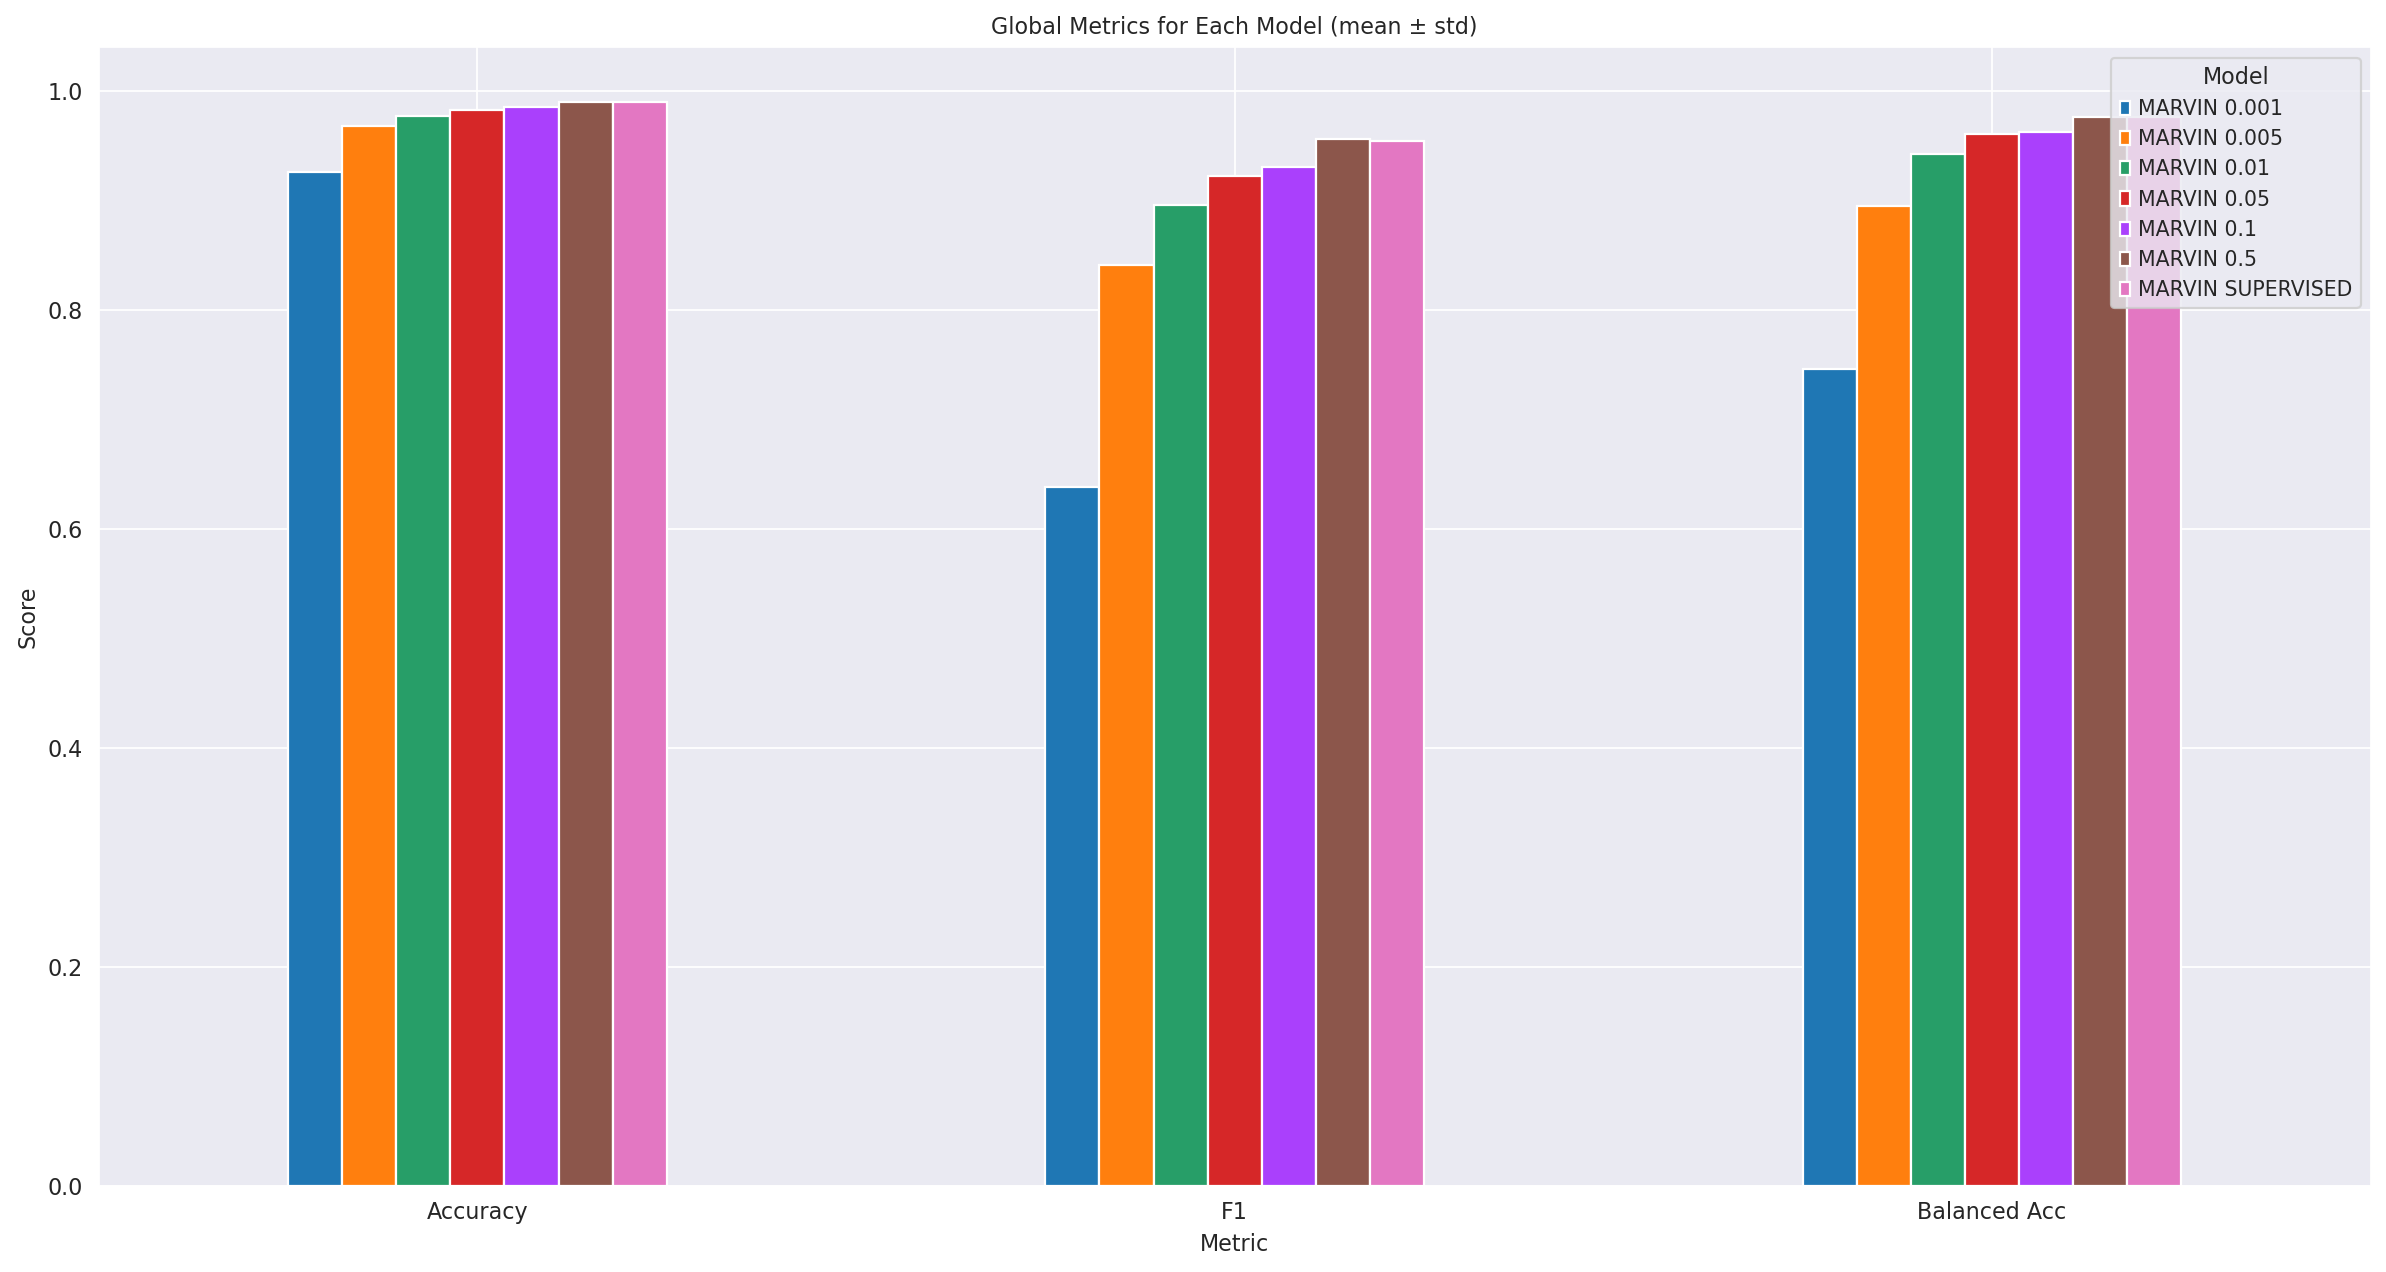

MARVIN 0.001, Accuracy: 0.9265 ± 0.0008
MARVIN 0.005, Accuracy: 0.9683 ± 0.0006
MARVIN 0.01, Accuracy: 0.9774 ± 0.0005
MARVIN 0.05, Accuracy: 0.9835 ± 0.0005
MARVIN 0.1, Accuracy: 0.9854 ± 0.0005
MARVIN 0.5, Accuracy: 0.9908 ± 0.0003
MARVIN SUPERVISED, Accuracy: 0.9903 ± 0.0003
MARVIN 0.001, F1: 0.6385 ± 0.0043
MARVIN 0.005, F1: 0.8418 ± 0.0037
MARVIN 0.01, F1: 0.8961 ± 0.0034
MARVIN 0.05, F1: 0.9231 ± 0.0038
MARVIN 0.1, F1: 0.9307 ± 0.0022
MARVIN 0.5, F1: 0.9563 ± 0.0027
MARVIN SUPERVISED, F1: 0.9552 ± 0.0032
MARVIN 0.001, Balanced Acc: 0.7462 ± 0.0038
MARVIN 0.005, Balanced Acc: 0.8952 ± 0.0026
MARVIN 0.01, Balanced Acc: 0.9425 ± 0.0024
MARVIN 0.05, Balanced Acc: 0.9608 ± 0.0016
MARVIN 0.1, Balanced Acc: 0.9630 ± 0.0014
MARVIN 0.5, Balanced Acc: 0.9766 ± 0.0015
MARVIN SUPERVISED, Balanced Acc: 0.9766 ± 0.0015


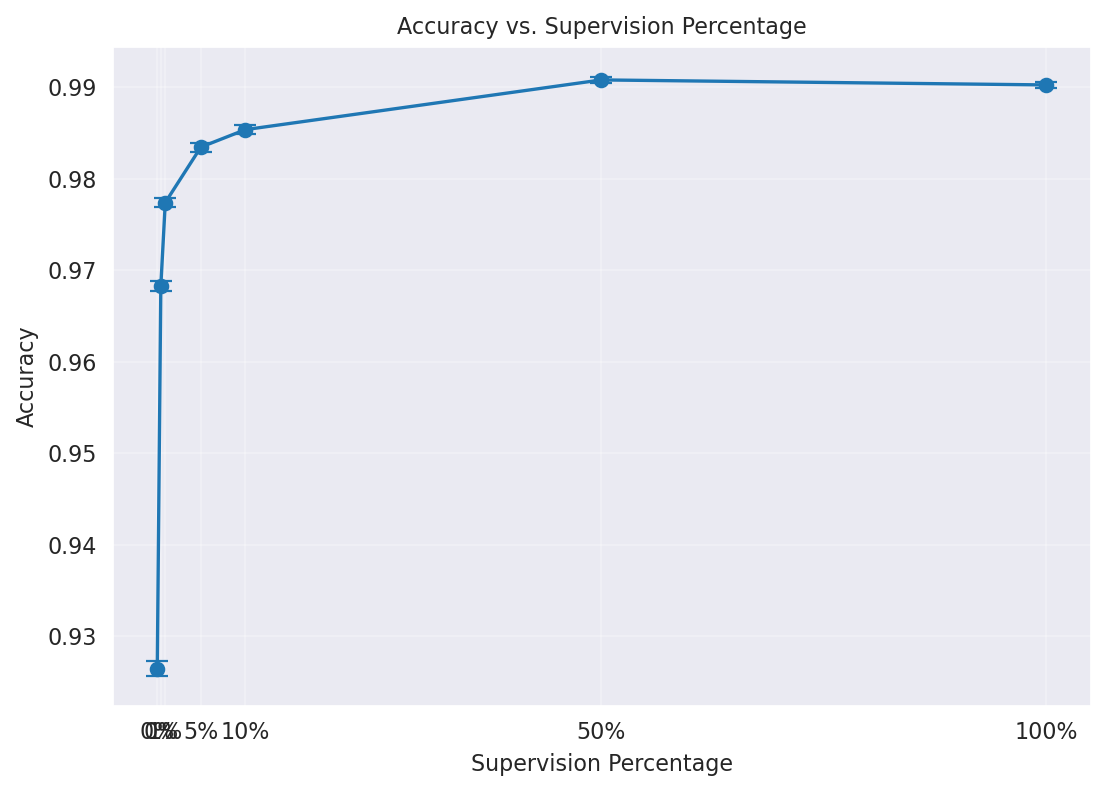

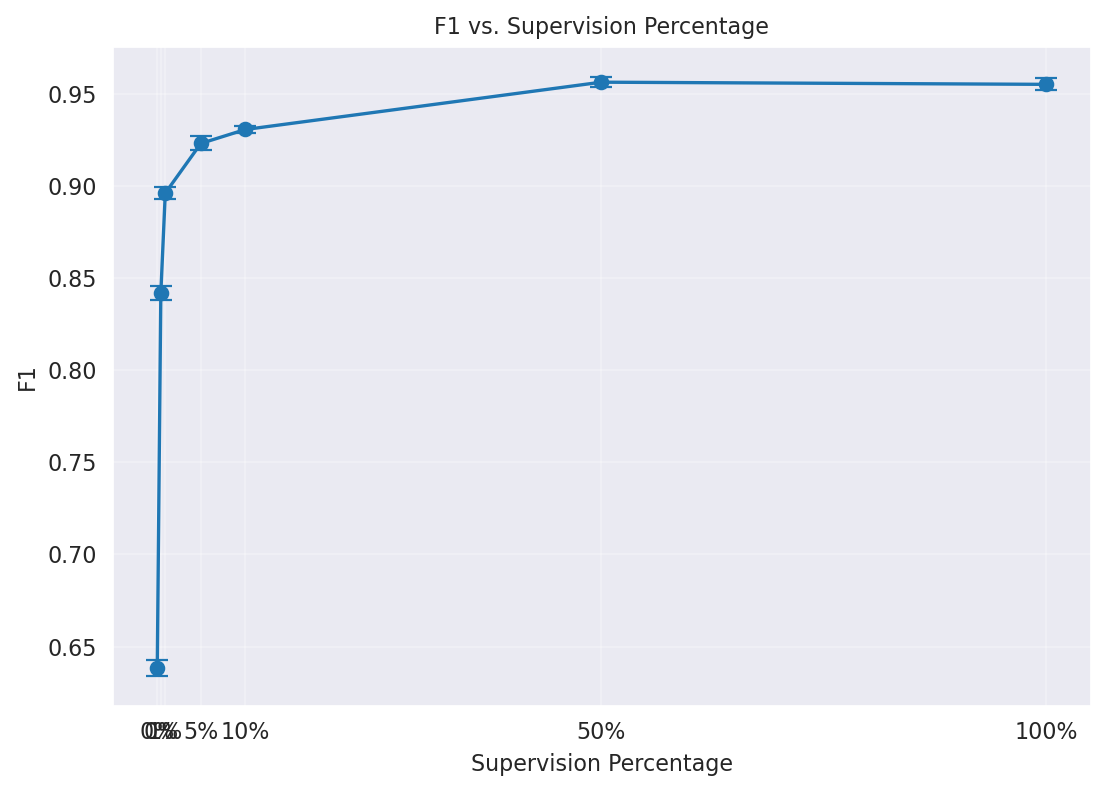

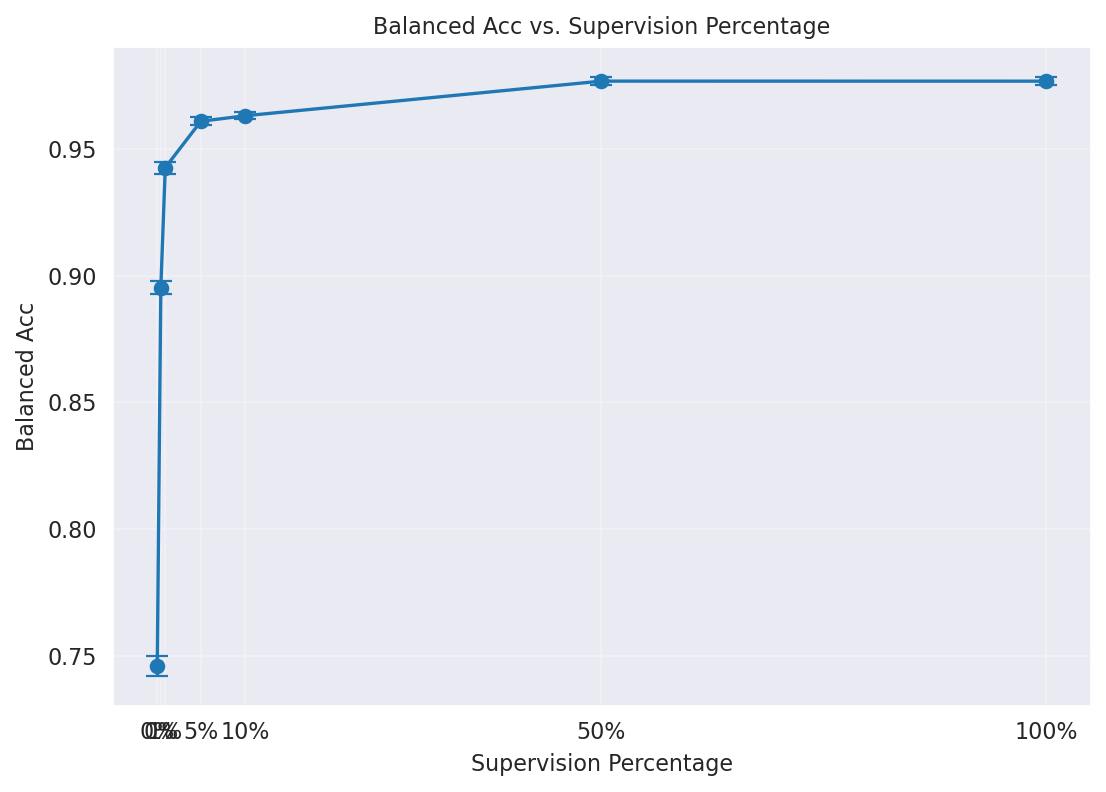

In [34]:
# Compute global metrics (mean and std) for each model using the repeated metrics function
model_names = ['MARVIN 0.001', 'MARVIN 0.005', 'MARVIN 0.01', 'MARVIN 0.05', 'MARVIN 0.1', 'MARVIN 0.5', 'MARVIN SUPERVISED']
global_metrics_mean = {'Accuracy': [], 'F1': [], 'Balanced Acc': []}
global_metrics_std = {'Accuracy': [], 'F1': [], 'Balanced Acc': []}

for name in model_names:
    res = metrics(testloader, models[name], n_repeats=10)
    global_metrics_mean['Accuracy'].append(res['accuracy_mean'])
    global_metrics_mean['F1'].append(res['f1_mean'])
    global_metrics_mean['Balanced Acc'].append(res['balanced_accuracy_mean'])
    global_metrics_std['Accuracy'].append(res['accuracy_std'])
    global_metrics_std['F1'].append(res['f1_std'])
    global_metrics_std['Balanced Acc'].append(res['balanced_accuracy_std'])

# Prepare DataFrame for plotting
metrics_mean_df = pd.DataFrame(global_metrics_mean, index=model_names).T
metrics_std_df = pd.DataFrame(global_metrics_std, index=model_names).T

# Plot with error bars (std)
sns.set_style("darkgrid")
ax = metrics_mean_df.plot(kind='bar', capsize=4, figsize=(15, 8))
plt.title("Global Metrics for Each Model (mean ± std)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("PLOTS/supervision_effect.svg")
plt.show()

for metric in metrics_mean_df.index:
    for model_name in metrics_mean_df.columns:
        mean = metrics_mean_df.loc[metric, model_name]
        std = metrics_std_df.loc[metric, model_name]
        print(f"{model_name}, {metric}: {mean:.4f} ± {std:.4f}")

# Define supervision percentages for each model (in the same order as model_names)
supervision_percents = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

score_names = ['Accuracy', 'F1', 'Balanced Acc']
for score in score_names:
    plt.figure(figsize=(7, 5))
    means = metrics_mean_df.loc[score].values
    stds = metrics_std_df.loc[score].values
    plt.errorbar(
        supervision_percents, means, yerr=stds, fmt='-o', capsize=5, label=score
    )
    plt.title(f"{score} vs. Supervision Percentage")
    plt.xlabel("Supervision Percentage")
    plt.ylabel(score)
    plt.xticks(supervision_percents, [f"{int(p*100)}%" for p in supervision_percents])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"PLOTS/supervision_effect_{score.lower().replace(' ', '_')}.svg")
    plt.show()

In [32]:
x, c_true = next(iter(dataloader))
x = x.to(mymodel.device)
c_true = c_true.to(mymodel.device)

q_c_x_01 = F.softmax(model0_1.q_c_x(x), dim=-1)
q_c_x_05 = F.softmax(model05.q_c_x(x), dim=-1)
q_c_x_1 = F.softmax(model1.q_c_x(x), dim=-1)
q_c_x_5 = F.softmax(model5.q_c_x(x), dim=-1)
q_c_x_10 = F.softmax(model10.q_c_x(x), dim=-1)
q_c_x_50 = F.softmax(model50.q_c_x(x), dim=-1)
q_c_x_sup = F.softmax(model.q_c_x(x), dim=-1)

c_01 = torch.multinomial(q_c_x_01, 1, replacement=True).squeeze()
c_05 = torch.multinomial(q_c_x_05, 1, replacement=True).squeeze()
c_1 = torch.multinomial(q_c_x_1, 1, replacement=True).squeeze()
c_5 = torch.multinomial(q_c_x_5, 1, replacement=True).squeeze()
c_10 = torch.multinomial(q_c_x_10, 1, replacement=True).squeeze()
c_50 = torch.multinomial(q_c_x_50, 1, replacement=True).squeeze()
c_sup = torch.multinomial(q_c_x_sup, 1, replacement=True).squeeze()

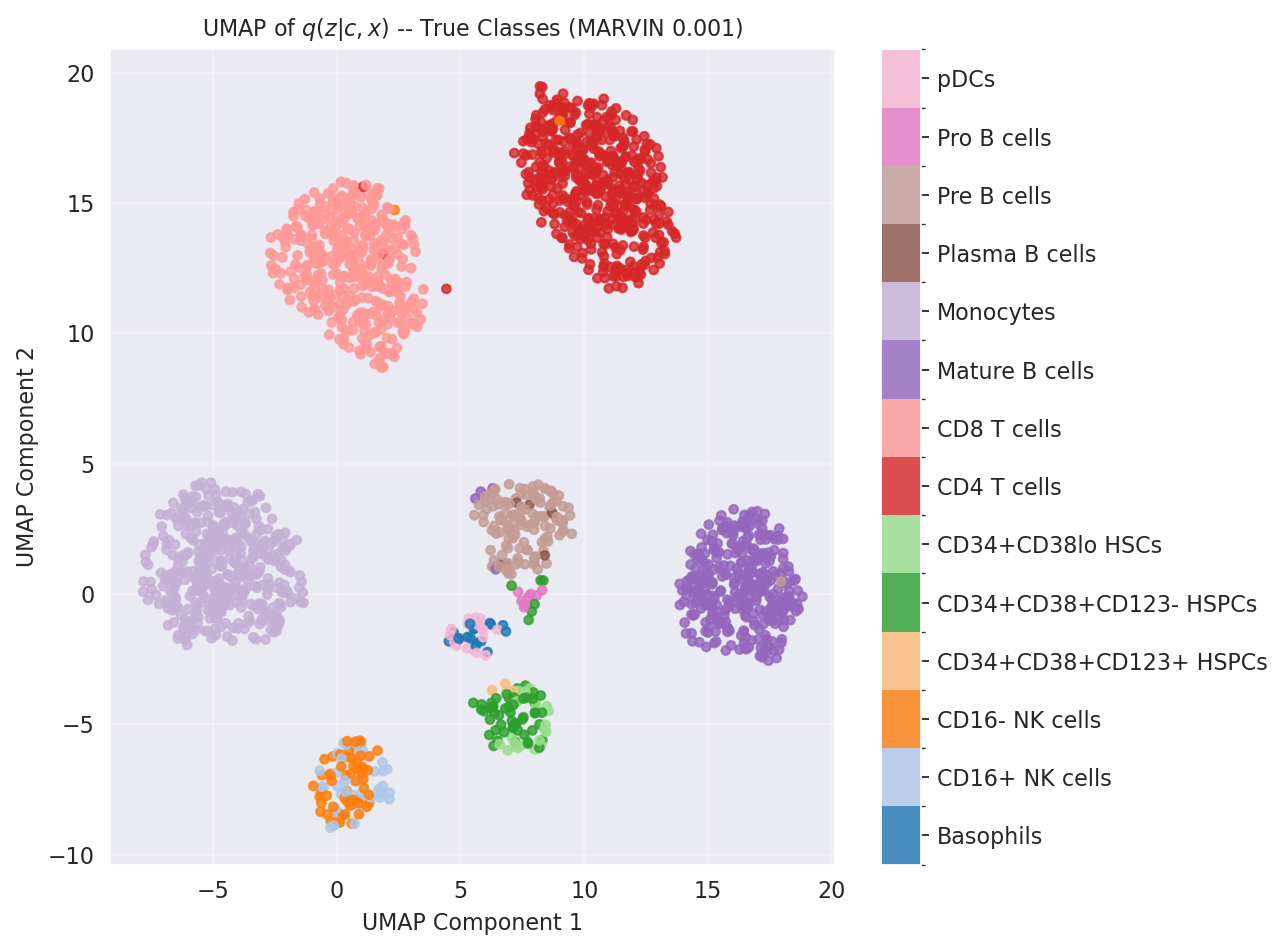

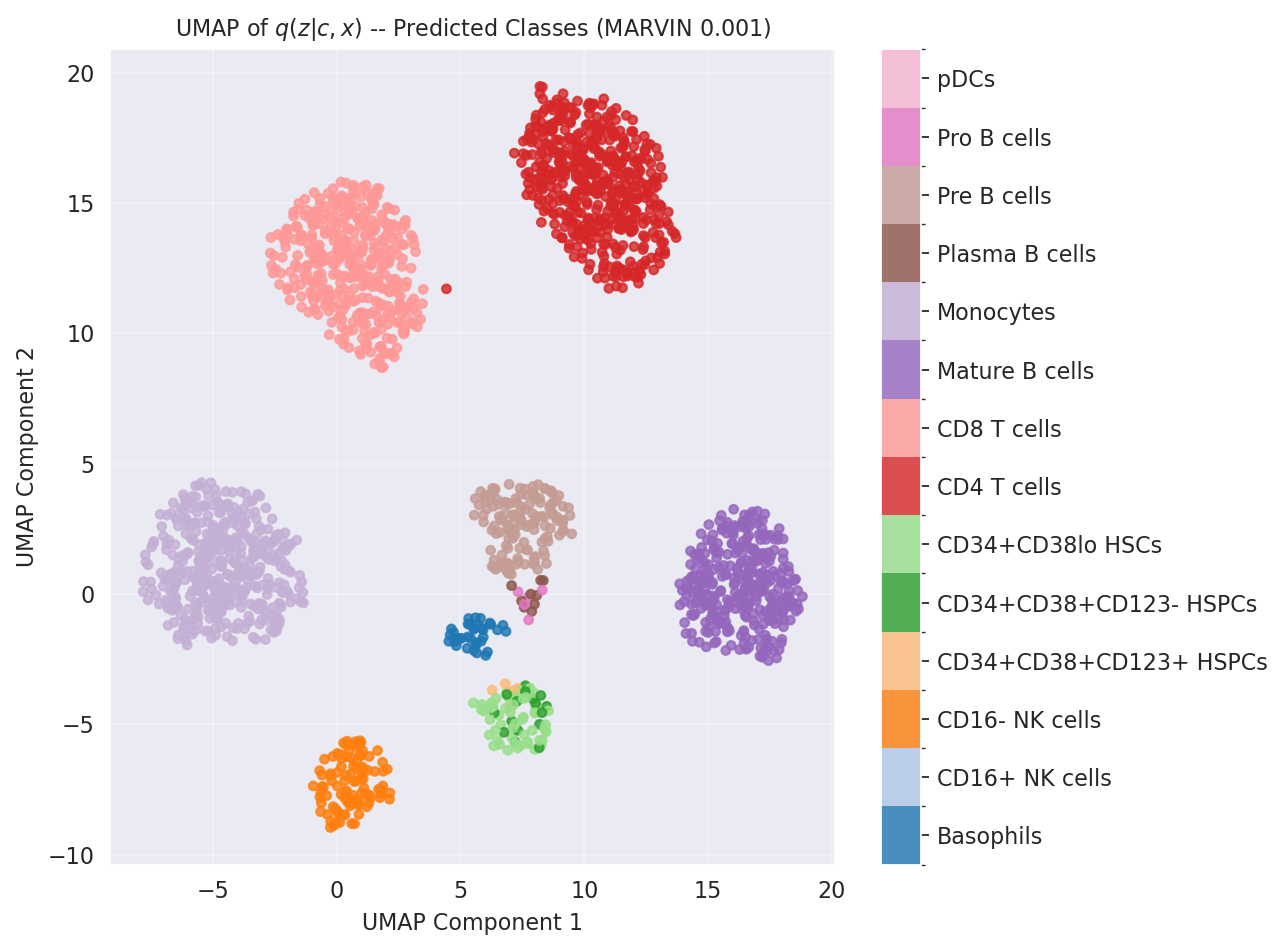

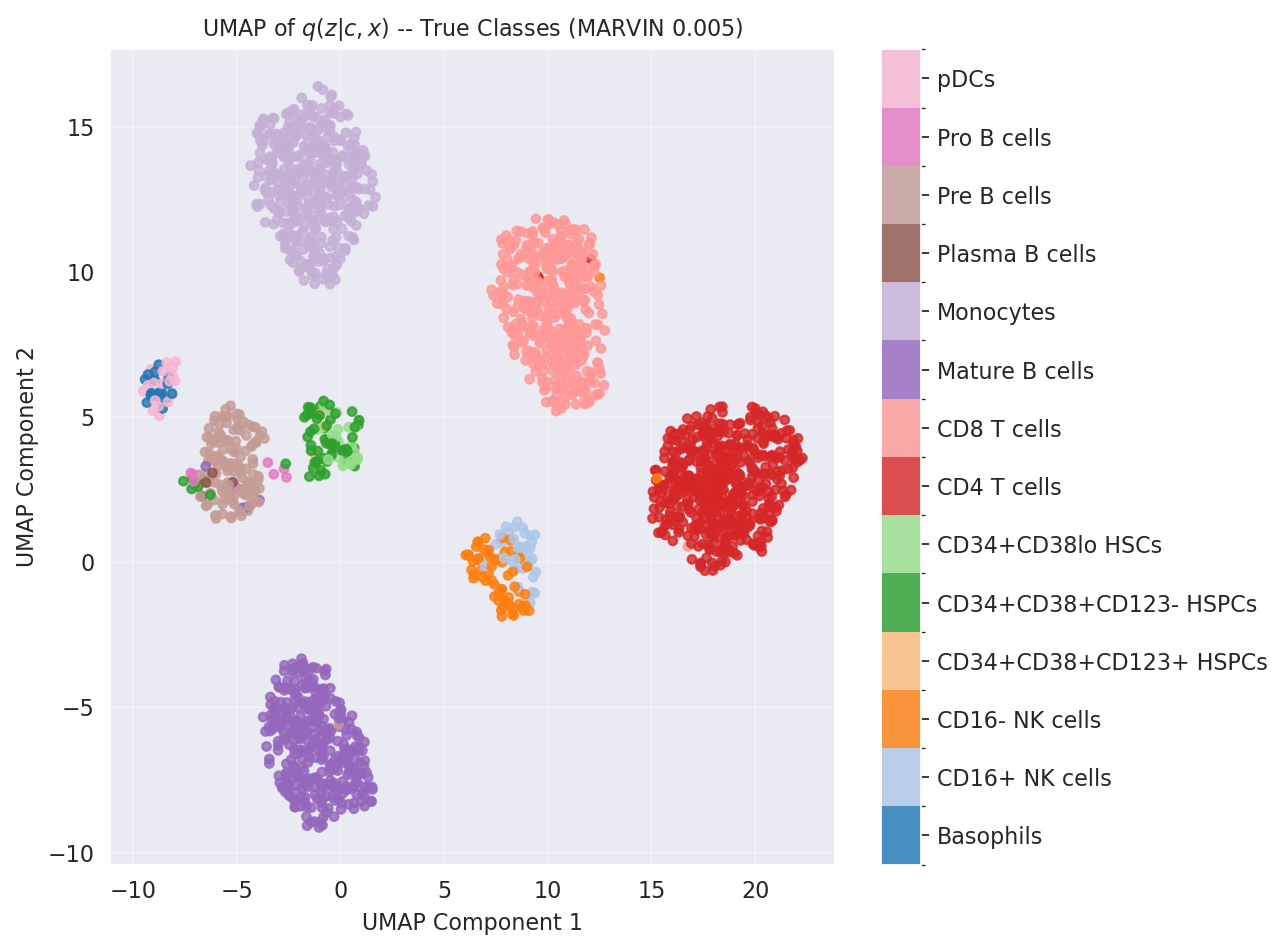

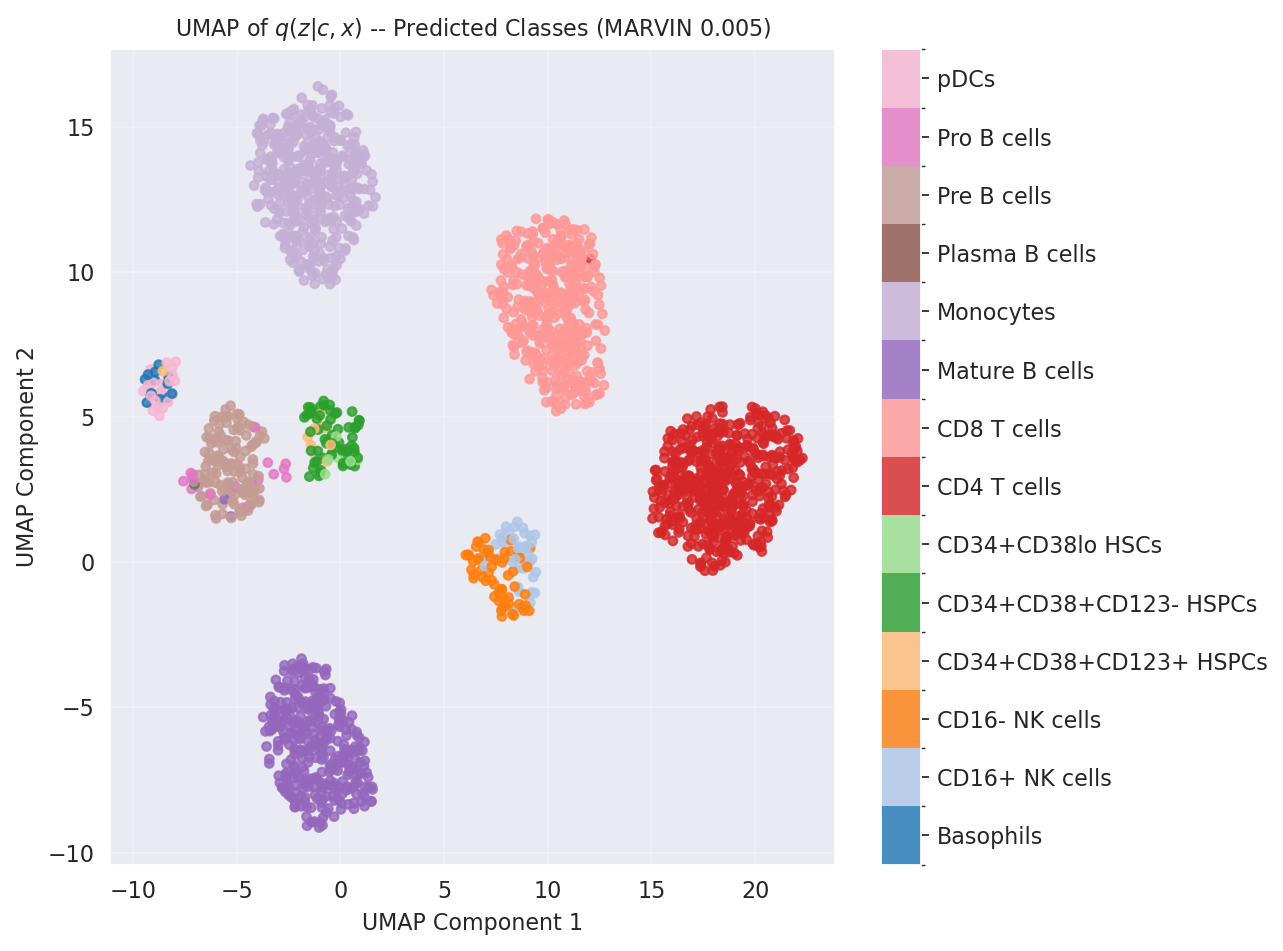

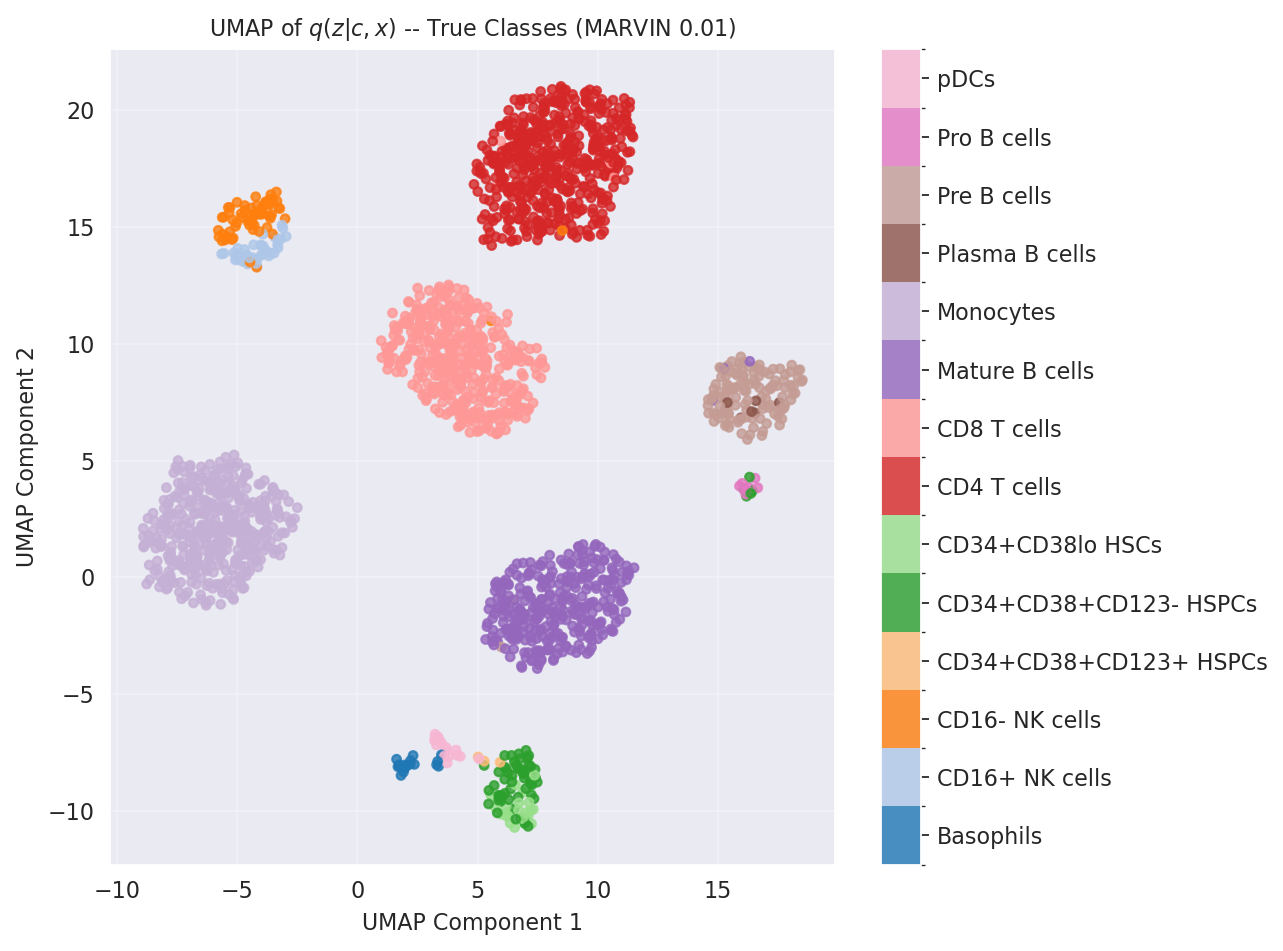

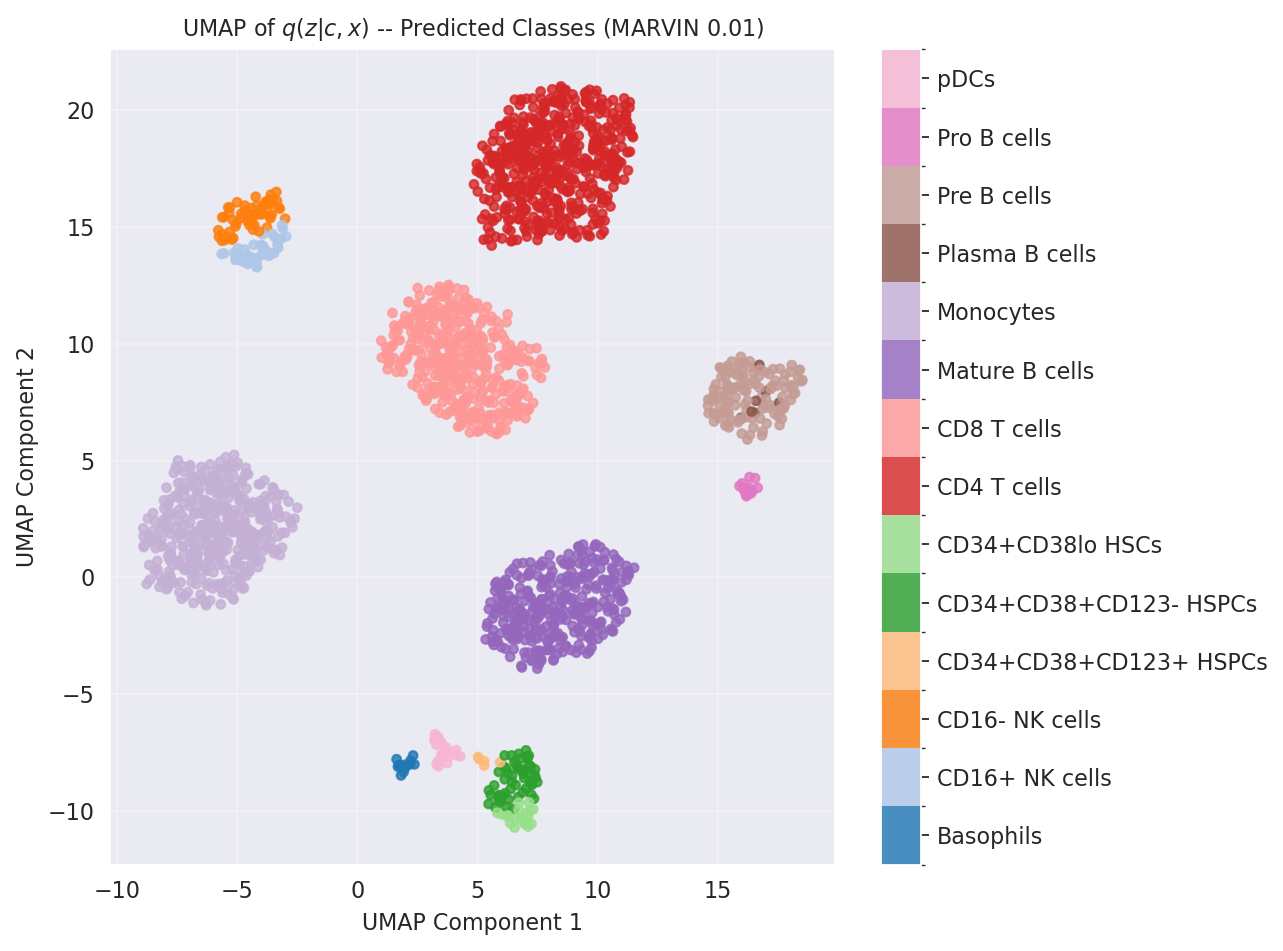

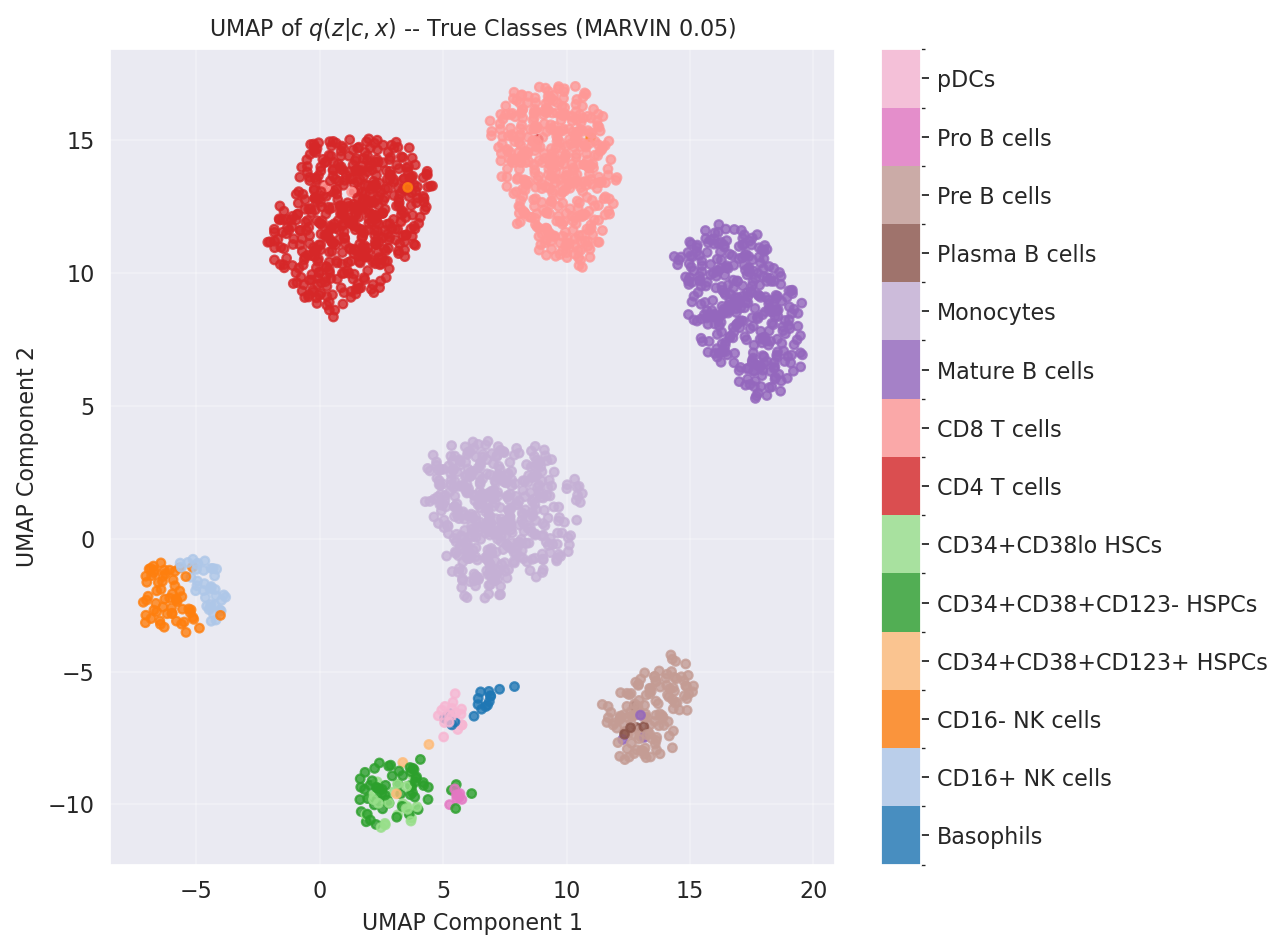

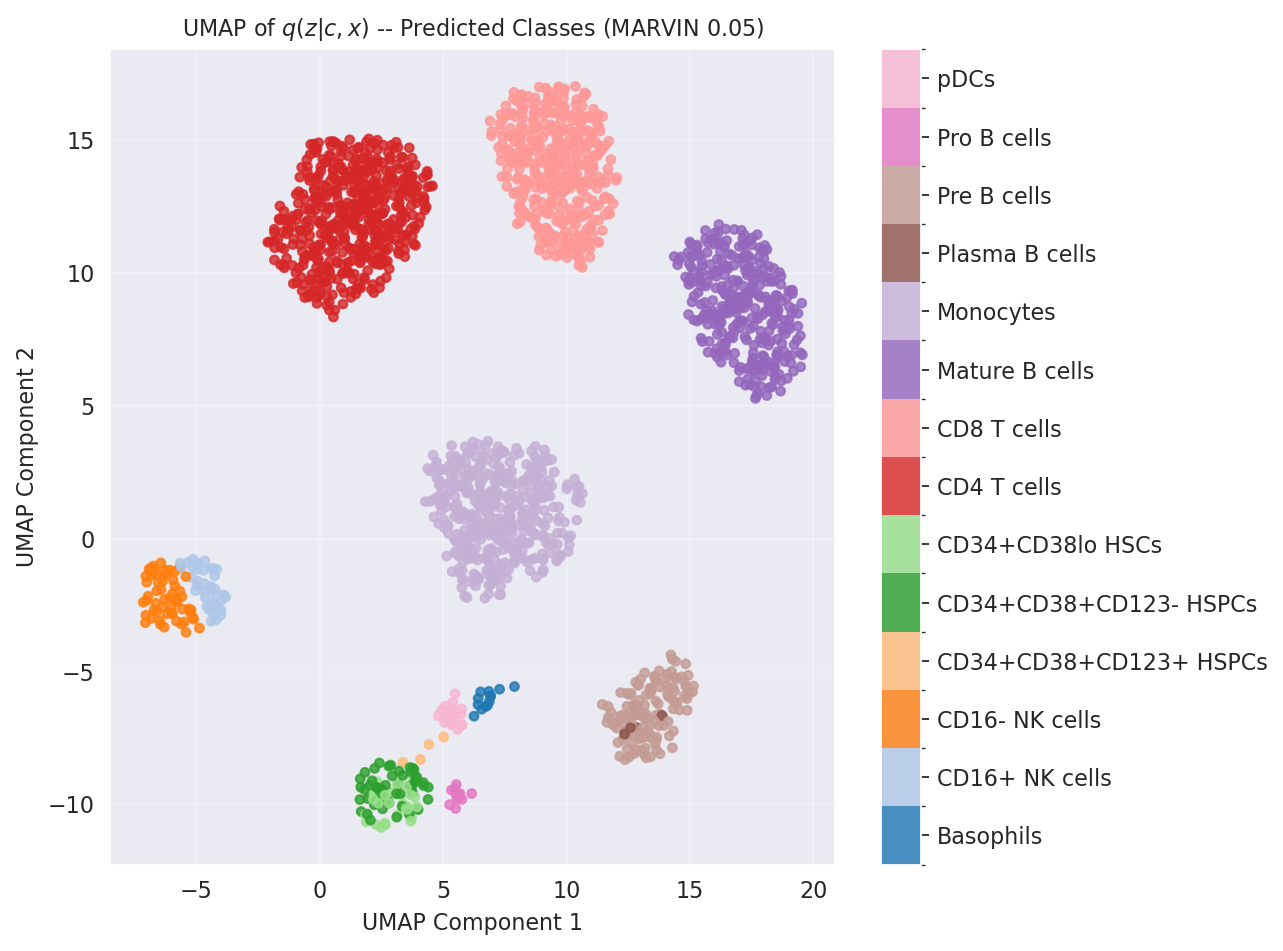

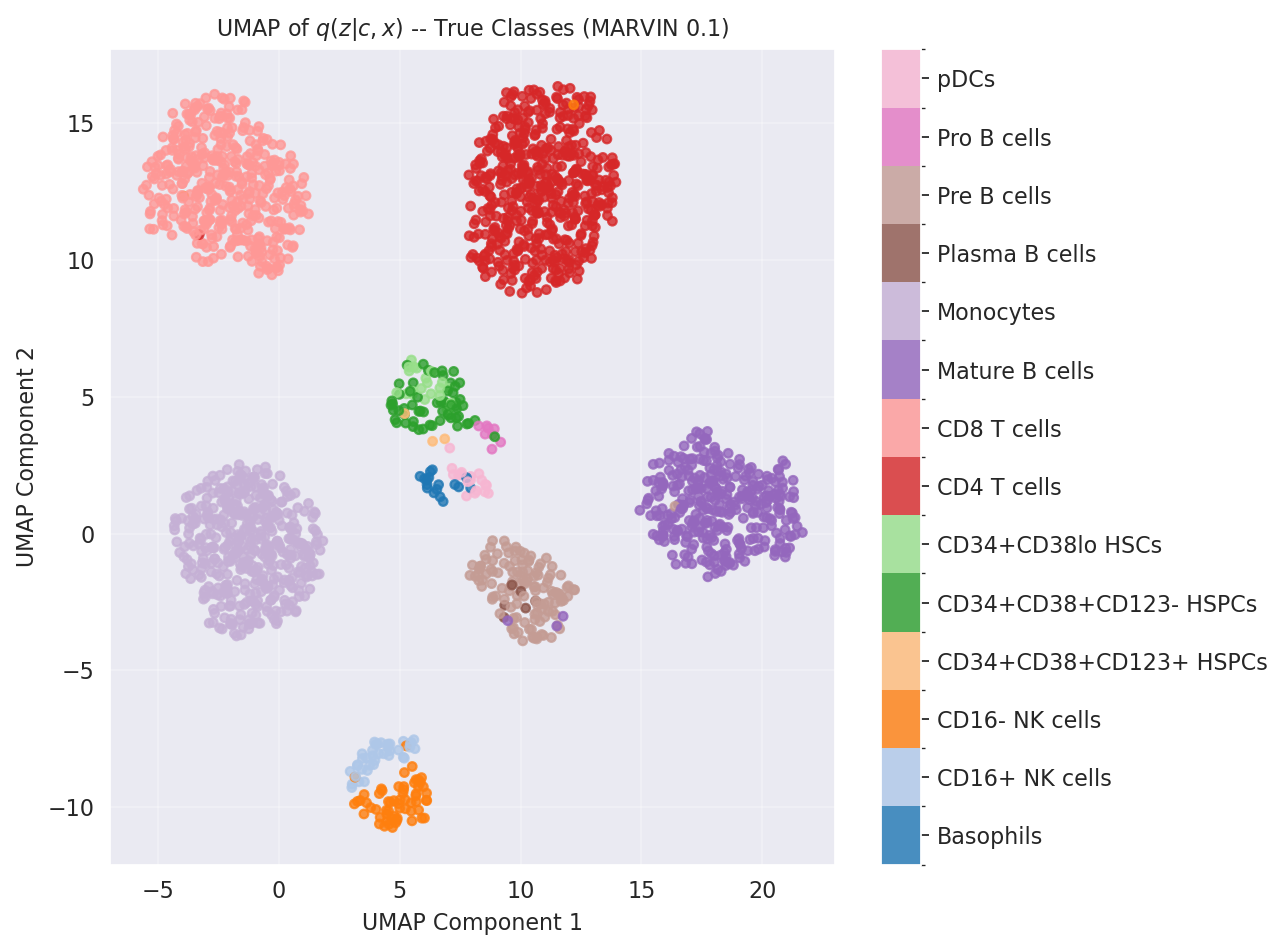

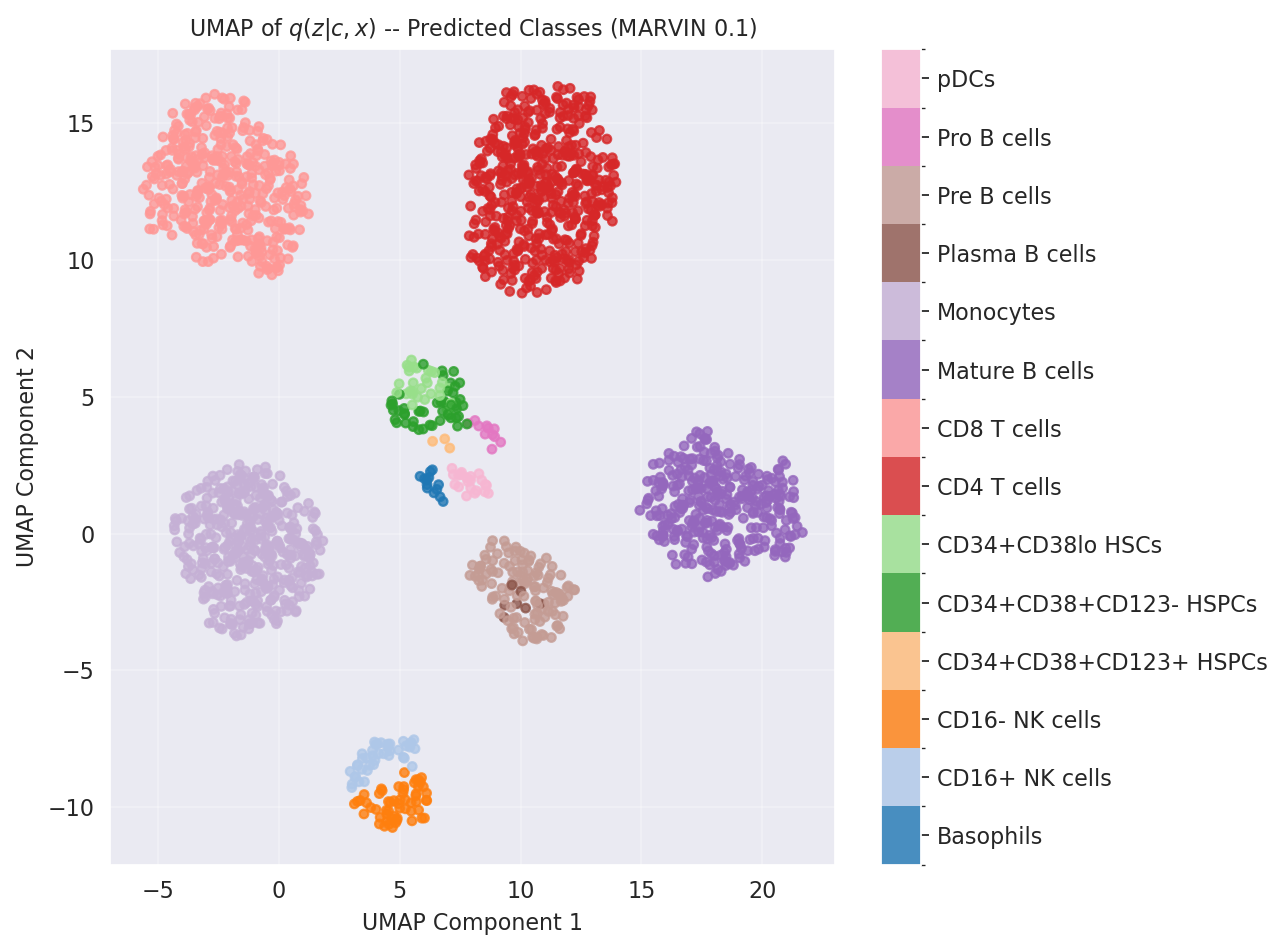

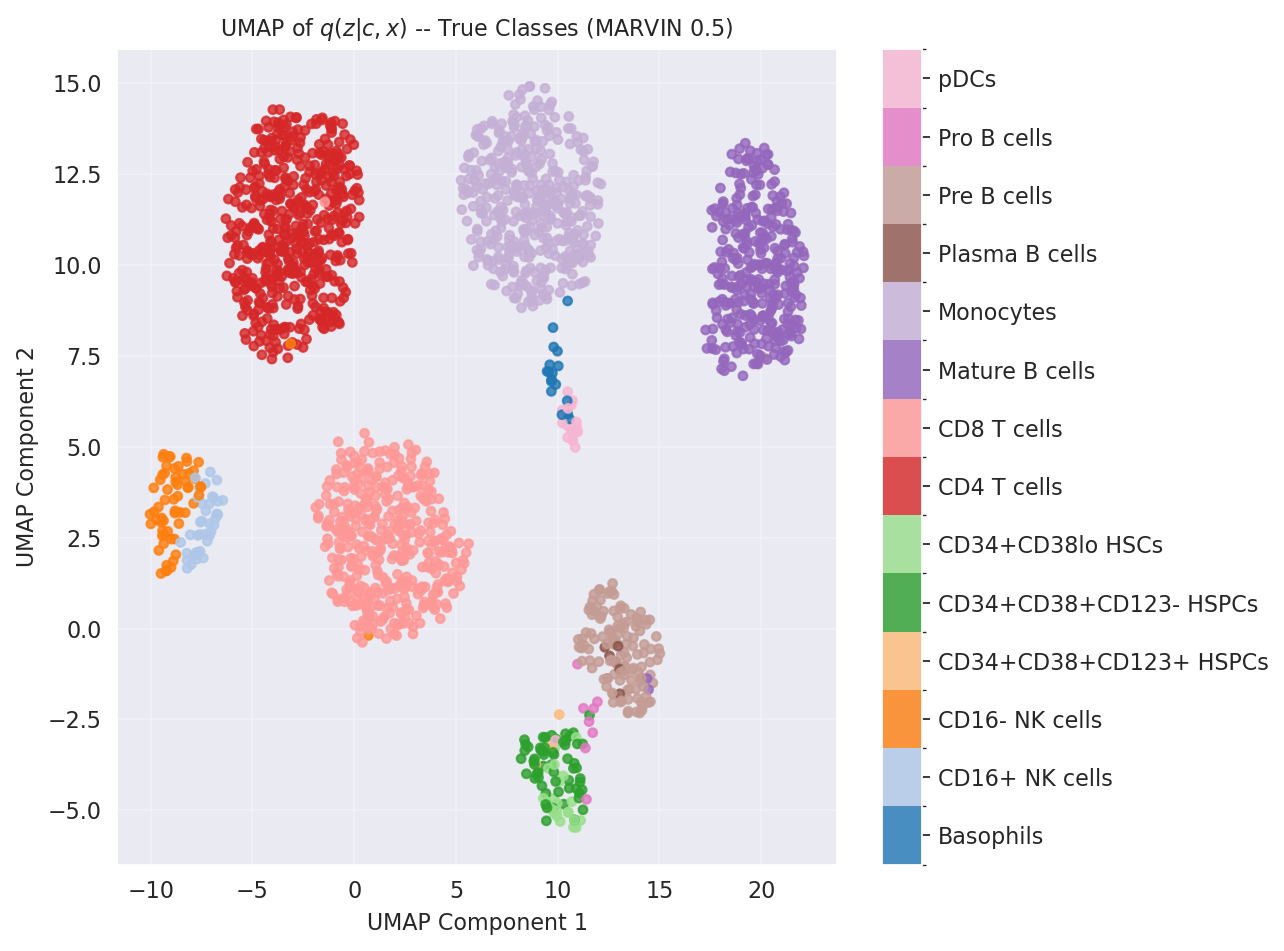

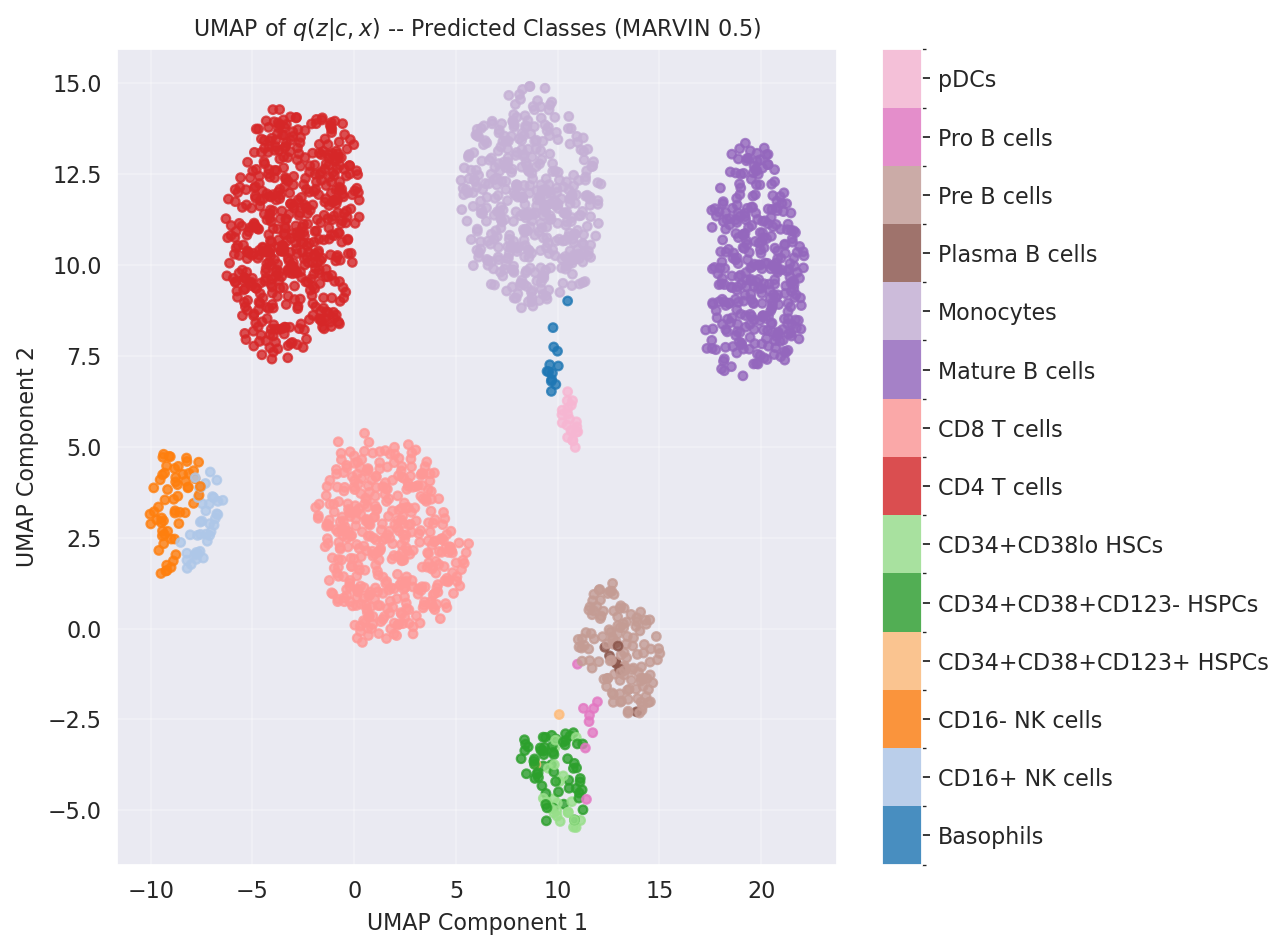

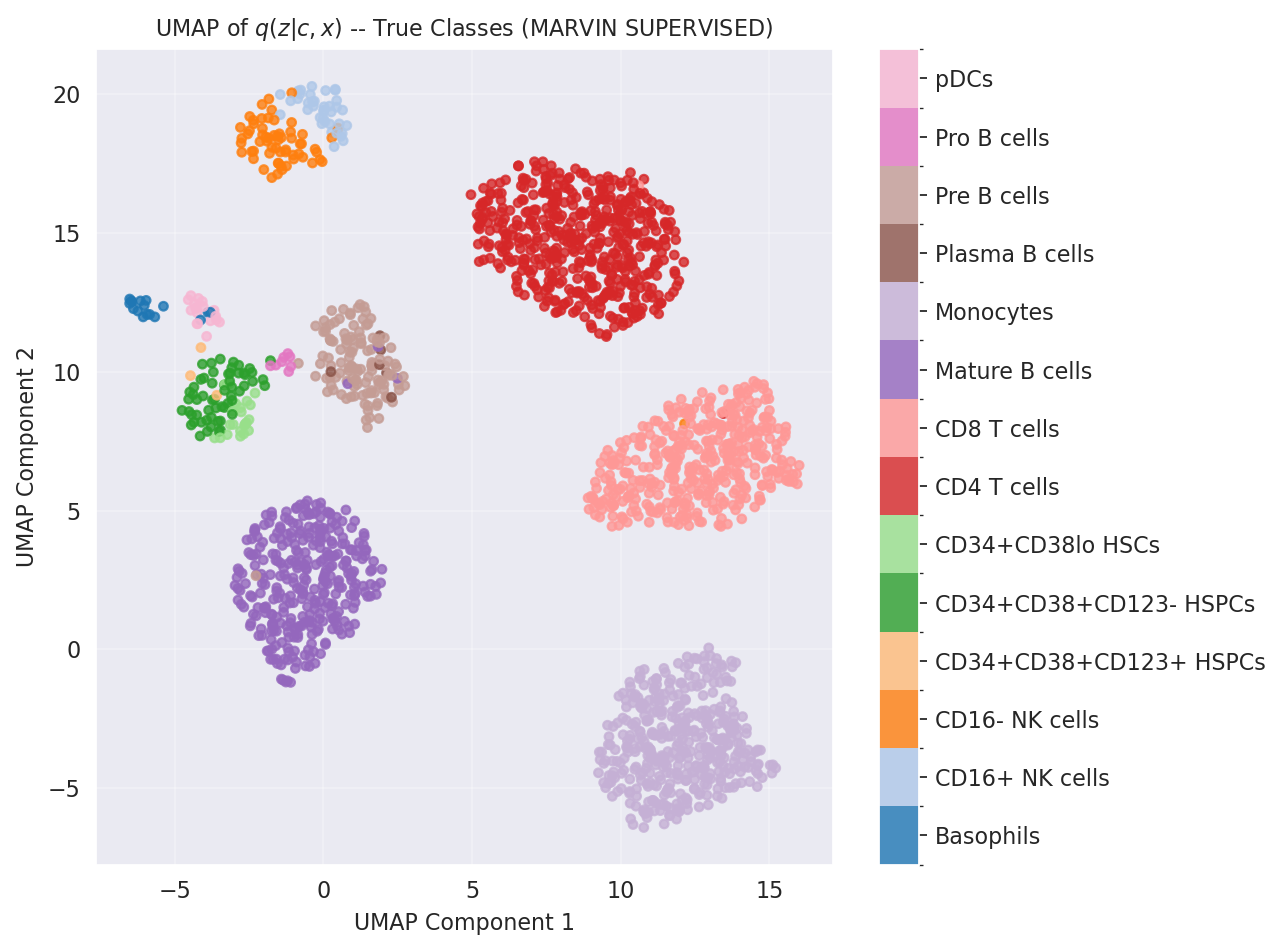

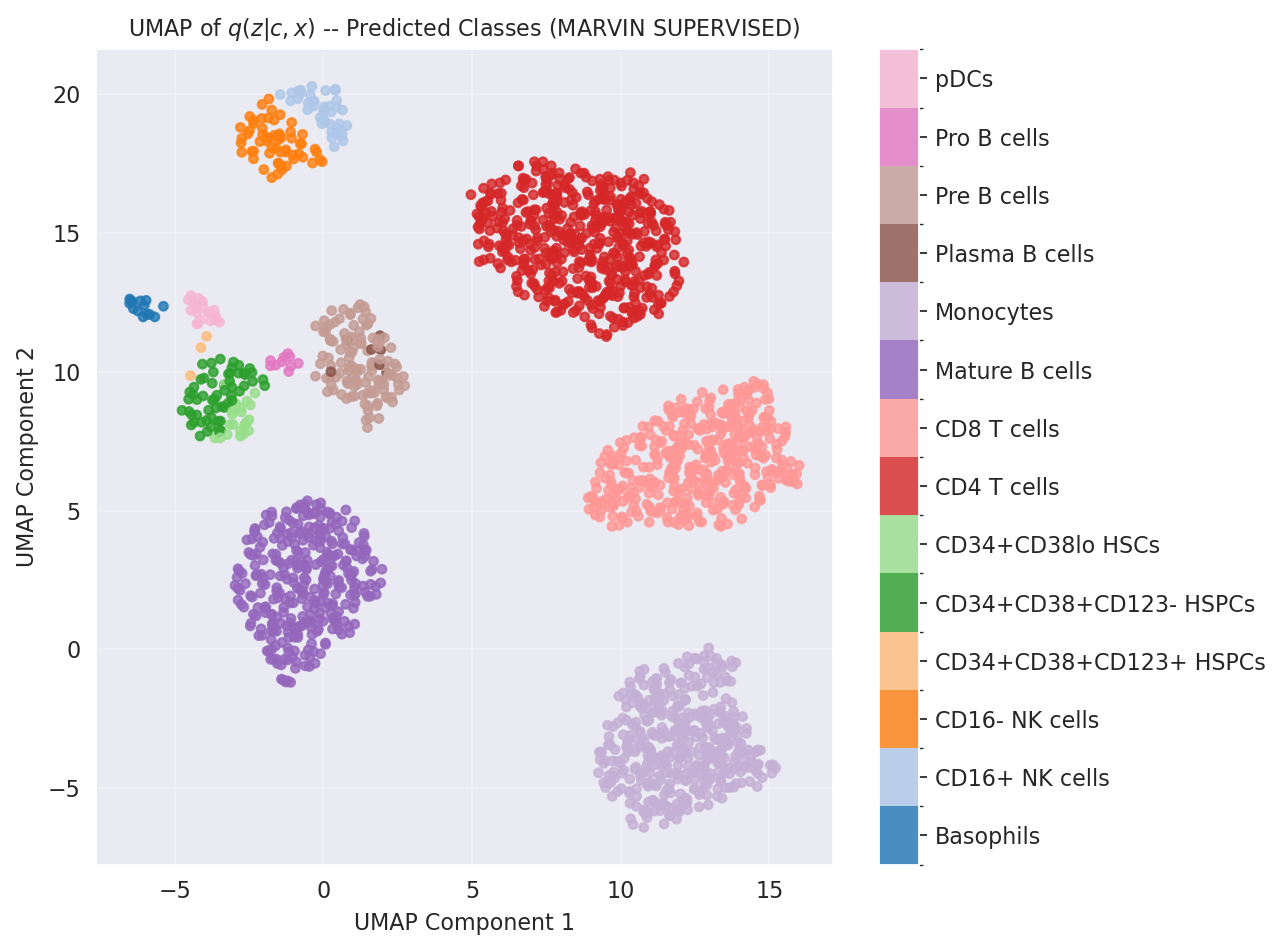

In [33]:
import umap.umap_ as umap
sns.set_style("darkgrid")
codes_01 = model0_1.one_hot(c_01, model0_1.K)
codes_05 = model05.one_hot(c_01, model0_1.K)
codes_1 = model1.one_hot(c_1, model1.K)
codes_5 = model5.one_hot(c_5, model5.K)
codes_10 = model10.one_hot(c_10, model10.K)
codes_50 = model50.one_hot(c_50, model50.K)
codes_sup = model.one_hot(c_sup, model.K)

q_z_cx_01 = model0_1.q_z_cx([codes_01, x])
q_z_cx_05 = model05.q_z_cx([codes_05, x])
q_z_cx_1 = model1.q_z_cx([codes_1, x])
q_z_cx_5 = model5.q_z_cx([codes_5, x])
q_z_cx_10 = model10.q_z_cx([codes_10, x])
q_z_cx_50 = model50.q_z_cx([codes_50, x])
q_z_cx_sup = model.q_z_cx([codes_sup, x])

mu_z_01 = q_z_cx_01[:, :model1.D]
logvar_z_01 = q_z_cx_01[:, model1.D:]
z_01 = mu_z_01 + logvar_z_01.exp().sqrt() * torch.randn_like(mu_z_01)

mu_z_05 = q_z_cx_05[:, :model1.D]
logvar_z_05 = q_z_cx_05[:, model1.D:]
z_05 = mu_z_05 + logvar_z_05.exp().sqrt() * torch.randn_like(mu_z_05)

mu_z_1 = q_z_cx_1[:, :model1.D]
logvar_z_1 = q_z_cx_1[:, model1.D:]
z_1 = mu_z_1 + logvar_z_1.exp().sqrt() * torch.randn_like(mu_z_1)

mu_z_5 = q_z_cx_5[:, :model5.D]
logvar_z_5 = q_z_cx_5[:, model5.D:]
z_5 = mu_z_5 + logvar_z_5.exp().sqrt() * torch.randn_like(mu_z_5)

mu_z_10 = q_z_cx_10[:, :model10.D]
logvar_z_10 = q_z_cx_10[:, model10.D:]
z_10 = mu_z_10 + logvar_z_10.exp().sqrt() * torch.randn_like(mu_z_10)

mu_z_50 = q_z_cx_50[:, :model50.D]
logvar_z_50 = q_z_cx_50[:, model50.D:]
z_50 = mu_z_50 + logvar_z_50.exp().sqrt() * torch.randn_like(mu_z_50)

mu_z_sup = q_z_cx_sup[:, :model.D]
logvar_z_sup = q_z_cx_sup[:, model.D:]
z_sup = mu_z_sup + logvar_z_sup.exp().sqrt() * torch.randn_like(mu_z_sup)

reducer = umap.UMAP(n_components=2, min_dist=0.8, n_neighbors=8)
zt_01= reducer.fit_transform(z_01.detach().cpu().numpy())
zt_05= reducer.fit_transform(z_05.detach().cpu().numpy())
zt_1 = reducer.fit_transform(z_1.detach().cpu().numpy())
zt_5 = reducer.fit_transform(z_5.detach().cpu().numpy())
zt_10 = reducer.fit_transform(z_10.detach().cpu().numpy())
zt_50 = reducer.fit_transform(z_50.detach().cpu().numpy())
zt_sup = reducer.fit_transform(z_sup.detach().cpu().numpy())

for zt, c_pred, model_name in zip(
    [zt_01, zt_05, zt_1, zt_5, zt_10, zt_50, zt_sup],
    [c_01, c_05, c_1, c_5, c_10, c_50, c_sup],
    ['MARVIN 0.001', 'MARVIN 0.005', 'MARVIN 0.01', 'MARVIN 0.05', 'MARVIN 0.1', 'MARVIN 0.5', 'MARVIN SUPERVISED']
):
    # Plot with true classes
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        zt[:, 0],
        zt[:, 1],
        c=[list(cluster_labels.keys()).index(label) for label in c_true.cpu().numpy()],
        cmap=ListedColormap(colors),
        norm=norm,
        s=15,
        alpha=0.8
    )
    colorbar = plt.colorbar(scatter, ticks=np.arange(len(cluster_labels)), boundaries=bounds)
    colorbar.set_ticks(tick_positions)
    colorbar.ax.set_yticklabels(cluster_labels.values())
    plt.title(f"UMAP of $q(z|c, x)$ -- True Classes ({model_name})")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/presentation/q_z_cx_true_{model_name.replace(' ', '_').lower()}.svg", dpi=150)
    plt.show()
    plt.close()

    # Plot with predicted classes
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        zt[:, 0],
        zt[:, 1],
        c=[list(cluster_labels.keys()).index(label) for label in c_pred.cpu().numpy()],
        cmap=ListedColormap(colors),
        norm=norm,
        s=15,
        alpha=0.8
    )
    colorbar = plt.colorbar(scatter, ticks=np.arange(len(cluster_labels)), boundaries=bounds)
    colorbar.set_ticks(tick_positions)
    colorbar.ax.set_yticklabels(cluster_labels.values())
    plt.title(f"UMAP of $q(z|c, x)$ -- Predicted Classes ({model_name})")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/presentation/q_z_cx_pred_{model_name.replace(' ', '_').lower()}.png", dpi=150)
    plt.show()
    plt.close()

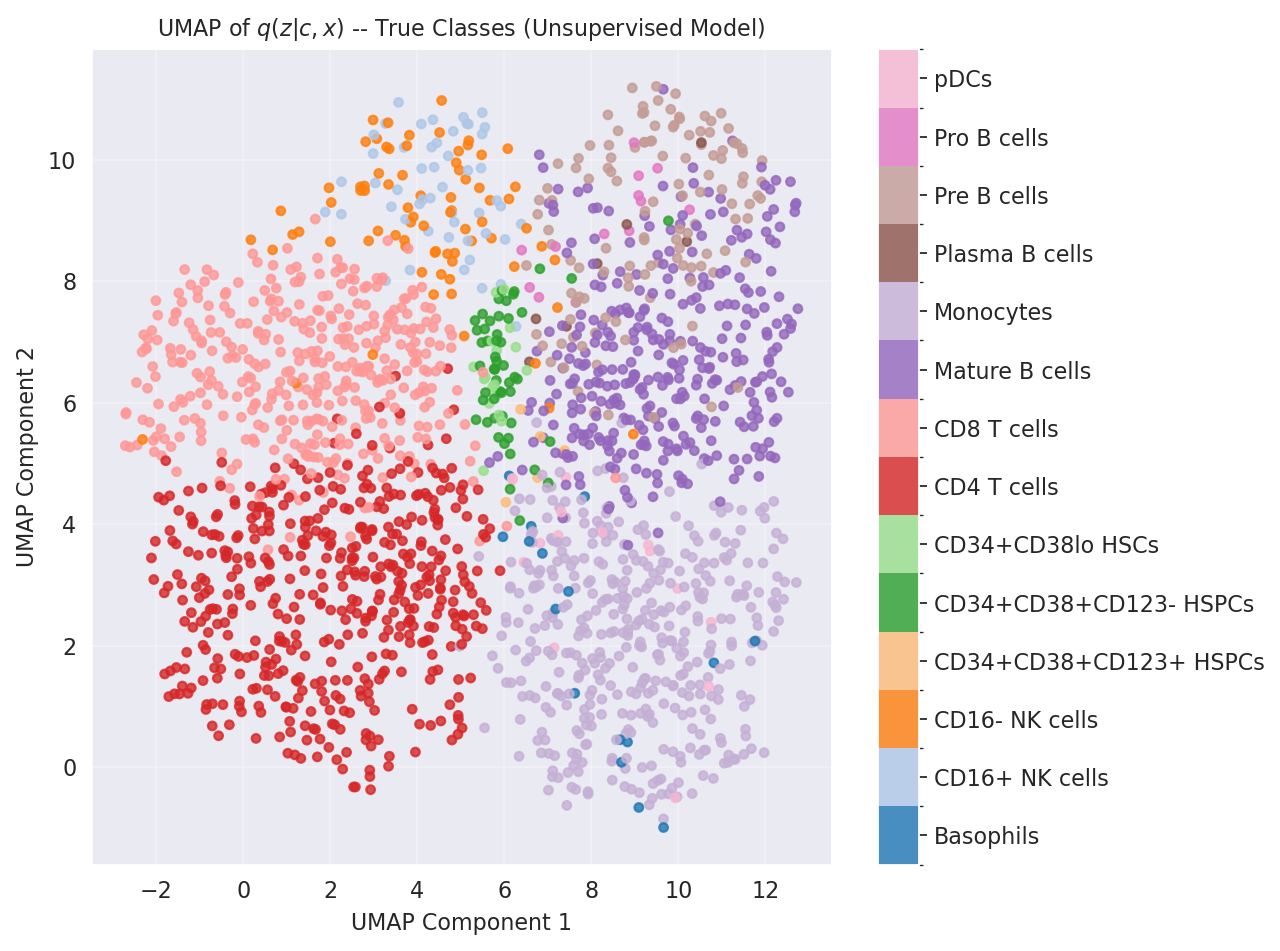

In [26]:
import umap.umap_ as umap
sns.set_style("darkgrid")
from gmvae_final_unsup import GMVAE
modelunsup = GMVAE(M,K,D,8,0.3,2)
modelunsup.load_state_dict(torch.load("wandb_follow/GMVAE_AML_unsup_final.pt", weights_only = True))
modelunsup.to(device)

#plot UMAP for unsupervised model
x, c_true = next(iter(dataloader))
x = x.to(modelunsup.device)
c_true = c_true.to(modelunsup.device)

q_c_x = F.softmax(modelunsup.q_c_x(x), dim=-1)
c = torch.multinomial(q_c_x, 1, replacement=True).squeeze() 

codes_unsup = modelunsup.one_hot(c_true, modelunsup.K)
q_z_cx_unsup = modelunsup.q_z_cx([codes_unsup, x])
mu_z_unsup = q_z_cx_unsup[:, :modelunsup.D]
logvar_z_unsup = q_z_cx_unsup[:, modelunsup.D:]
z_unsup = mu_z_unsup + logvar_z_unsup.exp().sqrt() * torch.randn_like(mu_z_unsup)
reducer_unsup = umap.UMAP(n_components=2, min_dist=0.8, n_neighbors=8)
zt_unsup = reducer_unsup.fit_transform(z_unsup.detach().cpu().numpy())
plt.figure(figsize=(8, 6))
scatter_unsup = plt.scatter(
    zt_unsup[:, 0],
    zt_unsup[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in c_true.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.8
)
colorbar_unsup = plt.colorbar(scatter_unsup, ticks=np.arange(len(cluster_labels)), boundaries=bounds)
colorbar_unsup.set_ticks(tick_positions)
colorbar_unsup.ax.set_yticklabels(cluster_labels.values())
plt.title(f"UMAP of $q(z|c, x)$ -- True Classes (Unsupervised Model)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(f"figures/presentation/q_z_cx_unsup.svg", dpi=150)

plt.show()
plt.close()